# Evaluation

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import keras
import keras.preprocessing.image
from keras_retinanet.models.resnet import custom_objects
from keras_retinanet.preprocessing.csv_generator import CSVGenerator

import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time
import pickle

Using TensorFlow backend.
/home/appsyoon/miniconda3/envs/capstone/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


## Loss

This model has two loss functions. One for the classification subnet, the other for the bounding box regression subnet.

Plot the total, regression and classification losses with validation and save figs.

In [2]:
def plot_loss_history(history_path):
    with (open(history_path, 'rb')) as file:
        history = pickle.load(file)
    
    # get the history file name for savefig
    title, _ = os.path.splitext(history_path)
    
    # validation losses
    val_loss = history['val_loss']
    val_regression_loss = history['val_regression_loss']
    val_classification_loss = history['val_classification_loss']

    # training losses
    loss = history['loss']
    regression_loss = history['regression_loss']
    classification_loss = history['classification_loss']

    plt.title('Loss')
    plt.plot(val_loss, 'r', loss, 'b')
    plt.savefig(title + '_loss.png')
    plt.show()

    plt.title('Classification Loss')
    plt.plot(val_classification_loss, 'r', regression_loss, 'b')
    plt.savefig(title + '_cl_loss.png')
    plt.show()

    plt.title('Regression Loss')
    plt.plot(val_regression_loss, 'r', regression_loss, 'b')
    plt.savefig(title + '_reg_loss.png')
    plt.show()

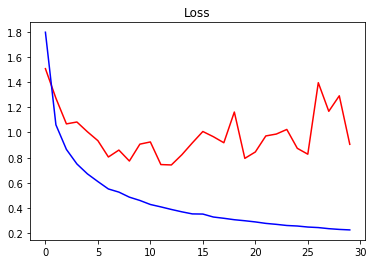

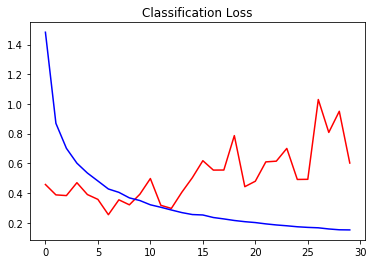

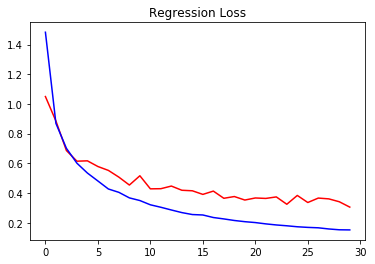

In [3]:
plot_loss_history('history_30_5000.pkl')

## AP/AR

This section loads the trained model and creates a submission text file for the VIVA Hand Detection Challenge evaluation kit to evaluate.

In [12]:
model = keras.models.load_model('./snapshots/resnet50_csv_12.h5', custom_objects=custom_objects)
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
padding_conv1 (ZeroPadding2D)   (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9408        padding_conv1[0][0]              
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________________
conv1_relu

/home/appsyoon/miniconda3/envs/capstone/lib/python3.6/site-packages/keras/models.py:252: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [13]:
test_generator = keras.preprocessing.image.ImageDataGenerator()
csv_test_generator = CSVGenerator(
    './data/test.csv',
    './data/classes.csv',
    test_generator,
    batch_size=1,
)

In [14]:
def get_detections_for_image(image, model, generator):
    # preprocess image for network
    image = csv_test_generator.preprocess_image(image)
    image, scale = csv_test_generator.resize_image(image)

    # process image
    start = time.time()
    _, _, detections = model.predict_on_batch(np.expand_dims(image, axis=0))
    print("processing time: ", time.time() - start)

    # correct for image scale
    detections[0, :, :4] /= scale
    
    return detections

Test prediction on a random image.

processing time:  3.509213447570801


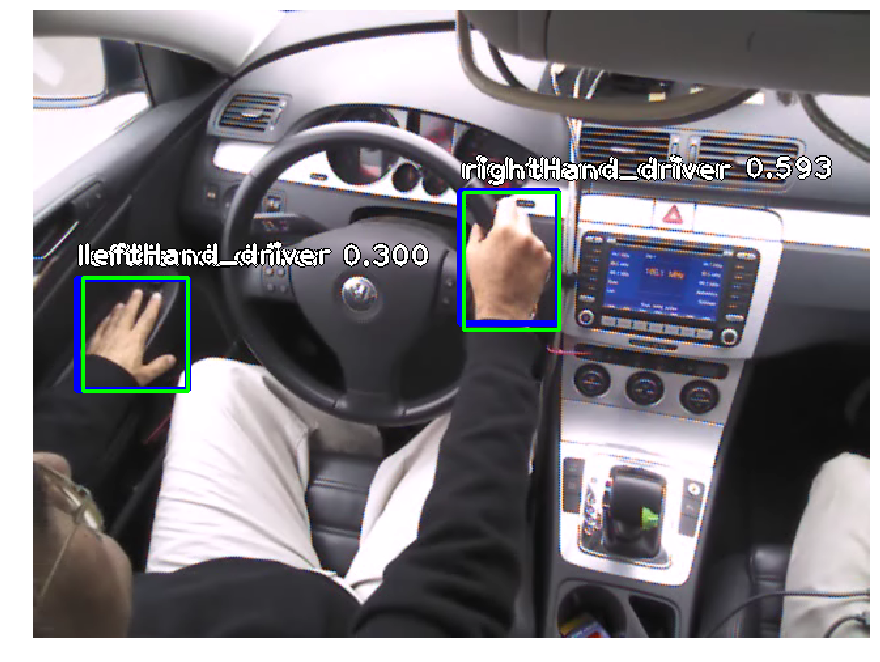

In [15]:
from random import randint

test_index = randint(0,csv_test_generator.size())
# load image
image = csv_test_generator.load_image(test_index)

# copy to draw on
draw = image.copy()
draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)
    
detections = get_detections_for_image(image, model, csv_test_generator)

# compute predicted labels and scores
predicted_labels = np.argmax(detections[0, :, 4:], axis=1)
scores = detections[0, np.arange(detections.shape[1]), 4 + predicted_labels]

# visualize detections
for idx, (label, score) in enumerate(zip(predicted_labels, scores)):
    if score < 0.25:
        continue
    b = detections[0, idx, :4].astype(int)
    cv2.rectangle(draw, (b[0], b[1]), (b[2], b[3]), (0, 0, 255), 3)
    caption = "{} {:.3f}".format(csv_test_generator.label_to_name(label), score)
    cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 0, 0), 3)
    cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (255, 255, 255), 2)

annotations = csv_test_generator.load_annotations(test_index)

# visualize annotations
for annotation in annotations:
    label = int(annotation[4])
    b = annotation[:4].astype(int)
    cv2.rectangle(draw, (b[0], b[1]), (b[2], b[3]), (0, 255, 0), 2)
    caption = "{}".format(csv_test_generator.label_to_name(label))
    cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 0, 0), 3)
    cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (255, 255, 255), 2)
    
plt.figure(figsize=(15, 15))
plt.axis('off')
plt.imshow(draw)
plt.show()

A single detection example:

In [16]:
print(detections[0,100,:])

[  5.06221924e+02   5.04030132e+00   7.69803345e+02   1.49545044e+02
   3.53548955e-03   2.61572213e-03   3.37044476e-03   4.18426609e-03]


In [ ]:
entries = []

for index in range(csv_test_generator.size()):
    # load image
    image = csv_test_generator.load_image(index)

    # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    # preprocess image for network
    image = csv_test_generator.preprocess_image(image)
    image, scale = csv_test_generator.resize_image(image)
    annotations = csv_test_generator.load_annotations(index)

    # process image
    start = time.time()
    _, _, detections = model.predict_on_batch(np.expand_dims(image, axis=0))
    print("processing time: ", time.time() - start)

    # compute predicted labels and scores
    predicted_labels = np.argmax(detections[0, :, 4:], axis=1)
    scores = detections[0, np.arange(detections.shape[1]), 4 + predicted_labels]

    # correct for image scale
    detections[0, :, :4] /= scale

    # visualize detections
    for idx, (label, score) in enumerate(zip(predicted_labels, scores)):
        if score < 0.25:
            continue
        _, filename = os.path.split(csv_test_generator.image_path(index))
        filename, _ = os.path.splitext(filename)
        
        b = detections[0, idx, :4].astype(int)
        
        if b[0] < b[2]:
            x, y, w, h = float(b[0]), float(b[1]), float(b[2]-b[0]), float(b[3]-b[1])
        else:
            x, y, w, h = float(b[1]), float(b[0]), float(b[0]-b[2]), float(b[1]-b[3])
            
        entry = '{} {} {} {} {} {} -1 -1 -1'.format(filename, x, y, w, h, score)
        print(entry)
        entries.append(entry)

print('Found {} entries.'.format(len(entries)))
submission = '\n'.join(entries)
with open('submission_12_025.txt', 'w') as file:
    file.write(submission)

processing time:  3.168759346008301
10L_0015700_Q_1_4_5 203.0 261.0 88.0 76.0 0.3108328878879547 -1 -1 -1
10L_0015700_Q_1_4_5 476.0 351.0 74.0 70.0 0.30905649065971375 -1 -1 -1
processing time:  3.227785110473633
10L_0015701_Q_1_4_5 203.0 261.0 88.0 76.0 0.30893412232398987 -1 -1 -1
10L_0015701_Q_1_4_5 476.0 351.0 75.0 70.0 0.3082062602043152 -1 -1 -1
processing time:  3.176790714263916
10L_0015702_Q_1_4_5 204.0 261.0 86.0 76.0 0.304635614156723 -1 -1 -1
10L_0015702_Q_1_4_5 476.0 351.0 74.0 70.0 0.3028612434864044 -1 -1 -1
processing time:  3.1982696056365967
10L_0015703_Q_1_4_5 204.0 261.0 87.0 76.0 0.2959769070148468 -1 -1 -1
10L_0015703_Q_1_4_5 476.0 351.0 74.0 71.0 0.2950984239578247 -1 -1 -1
processing time:  3.1907079219818115
10L_0015704_Q_1_4_5 203.0 261.0 88.0 76.0 0.3000742495059967 -1 -1 -1
10L_0015704_Q_1_4_5 476.0 351.0 74.0 70.0 0.28981781005859375 -1 -1 -1
processing time:  3.1902377605438232
10L_0015705_Q_1_4_5 203.0 261.0 88.0 76.0 0.29477477073669434 -1 -1 -1
10L_0015

processing time:  3.1648030281066895
10L_0015755_Q_1_4_5 224.0 265.0 81.0 80.0 0.4398511052131653 -1 -1 -1
10L_0015755_Q_1_4_5 476.0 351.0 74.0 71.0 0.32067933678627014 -1 -1 -1
processing time:  3.1551177501678467
10L_0015756_Q_1_4_5 224.0 265.0 81.0 80.0 0.4149744510650635 -1 -1 -1
10L_0015756_Q_1_4_5 479.0 348.0 70.0 75.0 0.31543368101119995 -1 -1 -1
processing time:  3.1658496856689453
10L_0015757_Q_1_4_5 227.0 266.0 75.0 79.0 0.3956577479839325 -1 -1 -1
10L_0015757_Q_1_4_5 475.0 352.0 73.0 68.0 0.3349684476852417 -1 -1 -1
processing time:  3.1672234535217285
10L_0015758_Q_1_4_5 227.0 266.0 75.0 78.0 0.3950696885585785 -1 -1 -1
10L_0015758_Q_1_4_5 475.0 351.0 73.0 70.0 0.33600085973739624 -1 -1 -1
processing time:  3.177501678466797
10L_0015759_Q_1_4_5 227.0 265.0 75.0 79.0 0.4090001583099365 -1 -1 -1
10L_0015759_Q_1_4_5 475.0 351.0 74.0 70.0 0.3298674523830414 -1 -1 -1
processing time:  3.187732219696045
10L_0015761_Q_1_4_5 221.0 266.0 81.0 76.0 0.38651353120803833 -1 -1 -1
10L_00

processing time:  2.9347567558288574
10L_0015809_Q_1_4_5 267.0 288.0 54.0 73.0 0.5222324132919312 -1 -1 -1
10L_0015809_Q_1_4_5 476.0 352.0 73.0 69.0 0.3244886100292206 -1 -1 -1
processing time:  2.9272735118865967
10L_0015812_Q_1_4_5 276.0 296.0 54.0 70.0 0.5689007043838501 -1 -1 -1
10L_0015812_Q_1_4_5 191.0 308.0 51.0 80.0 0.3710649609565735 -1 -1 -1
10L_0015812_Q_1_4_5 476.0 351.0 73.0 69.0 0.32965442538261414 -1 -1 -1
processing time:  2.929636240005493
10L_0015813_Q_1_4_5 191.0 309.0 53.0 82.0 0.3896164000034332 -1 -1 -1
10L_0015813_Q_1_4_5 479.0 348.0 69.0 73.0 0.3210342824459076 -1 -1 -1
10L_0015813_Q_1_4_5 276.0 308.0 48.0 59.0 0.2948094308376312 -1 -1 -1
processing time:  2.9232683181762695
10L_0015814_Q_1_4_5 191.0 308.0 53.0 86.0 0.4332374930381775 -1 -1 -1
10L_0015814_Q_1_4_5 277.0 308.0 45.0 60.0 0.3245237171649933 -1 -1 -1
10L_0015814_Q_1_4_5 476.0 351.0 72.0 69.0 0.3102671802043915 -1 -1 -1
processing time:  2.935120105743408
10L_0015816_Q_1_4_5 188.0 309.0 55.0 82.0 0.39

processing time:  2.9181671142578125
10L_0015851_Q_1_4_5 191.0 312.0 53.0 81.0 0.42943358421325684 -1 -1 -1
10L_0015851_Q_1_4_5 369.0 311.0 66.0 83.0 0.3958382308483124 -1 -1 -1
10L_0015851_Q_1_4_5 476.0 351.0 73.0 70.0 0.32095232605934143 -1 -1 -1
processing time:  2.923543930053711
10L_0015852_Q_1_4_5 191.0 312.0 52.0 81.0 0.4275350868701935 -1 -1 -1
10L_0015852_Q_1_4_5 369.0 309.0 77.0 83.0 0.3568652868270874 -1 -1 -1
10L_0015852_Q_1_4_5 476.0 351.0 73.0 70.0 0.3013017177581787 -1 -1 -1
processing time:  2.9272878170013428
10L_0015853_Q_1_4_5 191.0 312.0 52.0 80.0 0.418373703956604 -1 -1 -1
10L_0015853_Q_1_4_5 368.0 308.0 84.0 84.0 0.29122981429100037 -1 -1 -1
10L_0015853_Q_1_4_5 480.0 347.0 69.0 75.0 0.2909848690032959 -1 -1 -1
processing time:  2.9245409965515137
10L_0015854_Q_1_4_5 191.0 312.0 52.0 80.0 0.4167679250240326 -1 -1 -1
10L_0015854_Q_1_4_5 481.0 347.0 68.0 75.0 0.2909052073955536 -1 -1 -1
10L_0015854_Q_1_4_5 367.0 308.0 89.0 86.0 0.25004124641418457 -1 -1 -1
processing

processing time:  2.931680679321289
10L_0015888_Q_1_4_5 191.0 311.0 53.0 84.0 0.45003542304039 -1 -1 -1
10L_0015888_Q_1_4_5 476.0 351.0 73.0 69.0 0.31692683696746826 -1 -1 -1
10L_0015888_Q_1_4_5 362.0 317.0 59.0 92.0 0.2748803496360779 -1 -1 -1
processing time:  2.9333128929138184
10L_0015889_Q_1_4_5 192.0 311.0 52.0 82.0 0.4012971818447113 -1 -1 -1
10L_0015889_Q_1_4_5 363.0 314.0 58.0 85.0 0.37544167041778564 -1 -1 -1
10L_0015889_Q_1_4_5 476.0 352.0 73.0 69.0 0.3187216818332672 -1 -1 -1
processing time:  2.936227560043335
10L_0015891_Q_1_4_5 192.0 311.0 52.0 81.0 0.40644410252571106 -1 -1 -1
10L_0015891_Q_1_4_5 364.0 316.0 55.0 85.0 0.33746638894081116 -1 -1 -1
10L_0015891_Q_1_4_5 476.0 352.0 73.0 70.0 0.30962833762168884 -1 -1 -1
processing time:  2.9251153469085693
10L_0015892_Q_1_4_5 192.0 310.0 52.0 82.0 0.3973885774612427 -1 -1 -1
10L_0015892_Q_1_4_5 363.0 317.0 55.0 89.0 0.3380253314971924 -1 -1 -1
10L_0015892_Q_1_4_5 476.0 352.0 73.0 69.0 0.3134506046772003 -1 -1 -1
processing 

processing time:  2.9190642833709717
10L_0015927_Q_1_4_5 368.0 315.0 56.0 79.0 0.46744072437286377 -1 -1 -1
10L_0015927_Q_1_4_5 192.0 312.0 52.0 81.0 0.422698438167572 -1 -1 -1
10L_0015927_Q_1_4_5 480.0 347.0 69.0 76.0 0.32069262862205505 -1 -1 -1
processing time:  2.9186034202575684
10L_0015928_Q_1_4_5 192.0 312.0 52.0 81.0 0.4393804669380188 -1 -1 -1
10L_0015928_Q_1_4_5 342.0 303.0 62.0 91.0 0.37887275218963623 -1 -1 -1
10L_0015928_Q_1_4_5 476.0 350.0 73.0 71.0 0.31515058875083923 -1 -1 -1
processing time:  2.919203996658325
10L_0015929_Q_1_4_5 192.0 312.0 52.0 80.0 0.4300265908241272 -1 -1 -1
10L_0015929_Q_1_4_5 333.0 303.0 60.0 83.0 0.34994304180145264 -1 -1 -1
10L_0015929_Q_1_4_5 476.0 350.0 73.0 71.0 0.30742061138153076 -1 -1 -1
processing time:  2.921673059463501
10L_0015930_Q_1_4_5 319.0 299.0 58.0 77.0 0.5508018136024475 -1 -1 -1
10L_0015930_Q_1_4_5 191.0 312.0 53.0 80.0 0.4232316017150879 -1 -1 -1
10L_0015930_Q_1_4_5 480.0 348.0 68.0 74.0 0.3051948547363281 -1 -1 -1
processin

processing time:  2.917832851409912
10L_0015995_Q_1_4_5 282.0 295.0 62.0 73.0 0.6072289347648621 -1 -1 -1
10L_0015995_Q_1_4_5 191.0 309.0 51.0 80.0 0.3654288053512573 -1 -1 -1
10L_0015995_Q_1_4_5 476.0 351.0 73.0 71.0 0.3406677842140198 -1 -1 -1
processing time:  2.927269458770752
10L_0016059_Q_1_4_5 254.0 231.0 81.0 106.0 0.4899107813835144 -1 -1 -1
10L_0016059_Q_1_4_5 192.0 310.0 52.0 86.0 0.3497096300125122 -1 -1 -1
10L_0016059_Q_1_4_5 477.0 352.0 72.0 70.0 0.27326831221580505 -1 -1 -1
processing time:  2.936012029647827
10L_0016061_Q_1_4_5 305.0 224.0 81.0 103.0 0.47881922125816345 -1 -1 -1
10L_0016061_Q_1_4_5 190.0 310.0 53.0 84.0 0.3680645823478699 -1 -1 -1
10L_0016061_Q_1_4_5 477.0 351.0 72.0 70.0 0.29841190576553345 -1 -1 -1
processing time:  2.920539140701294
10L_0016062_Q_1_4_5 190.0 310.0 53.0 86.0 0.3783404231071472 -1 -1 -1
10L_0016062_Q_1_4_5 334.0 214.0 86.0 104.0 0.31602078676223755 -1 -1 -1
10L_0016062_Q_1_4_5 476.0 351.0 73.0 70.0 0.2938716411590576 -1 -1 -1
processin

processing time:  2.9514384269714355
10L_0016103_Q_1_4_5 476.0 351.0 73.0 69.0 0.30085262656211853 -1 -1 -1
processing time:  2.9348254203796387
10L_0016104_Q_1_4_5 479.0 348.0 70.0 74.0 0.3093950152397156 -1 -1 -1
processing time:  2.9441959857940674
10L_0016105_Q_1_4_5 476.0 354.0 77.0 67.0 0.29399630427360535 -1 -1 -1
processing time:  2.9448416233062744
10L_0016106_Q_1_4_5 476.0 352.0 73.0 69.0 0.2934887707233429 -1 -1 -1
processing time:  2.9268198013305664
10L_0016107_Q_1_4_5 476.0 352.0 72.0 69.0 0.3094124495983124 -1 -1 -1
10L_0016107_Q_1_4_5 206.0 258.0 94.0 86.0 0.25207674503326416 -1 -1 -1
processing time:  2.9578237533569336
10L_0016108_Q_1_4_5 476.0 352.0 74.0 70.0 0.29186734557151794 -1 -1 -1
10L_0016108_Q_1_4_5 206.0 258.0 94.0 86.0 0.256239652633667 -1 -1 -1
processing time:  2.9523491859436035
10L_0016109_Q_1_4_5 476.0 352.0 74.0 70.0 0.2810363471508026 -1 -1 -1
10L_0016109_Q_1_4_5 206.0 258.0 94.0 86.0 0.2542451024055481 -1 -1 -1
processing time:  2.935986042022705
10

processing time:  2.929319143295288
10L_0016157_Q_1_4_5 186.0 257.0 99.0 82.0 0.38709983229637146 -1 -1 -1
10L_0016157_Q_1_4_5 480.0 348.0 69.0 74.0 0.32150715589523315 -1 -1 -1
processing time:  2.9317123889923096
10L_0016158_Q_1_4_5 185.0 255.0 100.0 84.0 0.34515026211738586 -1 -1 -1
10L_0016158_Q_1_4_5 477.0 351.0 72.0 69.0 0.3108578622341156 -1 -1 -1
processing time:  2.9379303455352783
10L_0016159_Q_1_4_5 180.0 253.0 101.0 84.0 0.3320060968399048 -1 -1 -1
10L_0016159_Q_1_4_5 477.0 351.0 72.0 70.0 0.29105520248413086 -1 -1 -1
processing time:  2.916637897491455
10L_0016160_Q_1_4_5 480.0 348.0 69.0 74.0 0.3091484606266022 -1 -1 -1
10L_0016160_Q_1_4_5 177.0 250.0 100.0 86.0 0.2975877523422241 -1 -1 -1
processing time:  2.9205446243286133
10L_0016161_Q_1_4_5 174.0 249.0 102.0 88.0 0.3893589973449707 -1 -1 -1
10L_0016161_Q_1_4_5 477.0 351.0 72.0 70.0 0.31574052572250366 -1 -1 -1
processing time:  2.9203426837921143
10L_0016166_Q_1_4_5 300.0 203.0 83.0 115.0 0.42808184027671814 -1 -1 -1

processing time:  2.9324963092803955
10L_0016437_Q_1_4_5 190.0 312.0 51.0 84.0 0.3477420508861542 -1 -1 -1
10L_0016437_Q_1_4_5 480.0 348.0 69.0 74.0 0.3121810257434845 -1 -1 -1
10L_0016437_Q_1_4_5 352.0 241.0 77.0 98.0 0.29037219285964966 -1 -1 -1
processing time:  2.9190807342529297
10L_0016439_Q_1_4_5 190.0 312.0 52.0 84.0 0.3551579713821411 -1 -1 -1
10L_0016439_Q_1_4_5 352.0 243.0 78.0 98.0 0.3415718376636505 -1 -1 -1
10L_0016439_Q_1_4_5 480.0 348.0 69.0 74.0 0.30698567628860474 -1 -1 -1
processing time:  2.9267985820770264
10L_0016441_Q_1_4_5 189.0 311.0 54.0 86.0 0.3451072573661804 -1 -1 -1
10L_0016441_Q_1_4_5 476.0 351.0 73.0 71.0 0.3053990304470062 -1 -1 -1
10L_0016441_Q_1_4_5 355.0 244.0 74.0 100.0 0.2930586040019989 -1 -1 -1
processing time:  2.9282963275909424
10L_0016442_Q_1_4_5 189.0 312.0 54.0 86.0 0.3264065682888031 -1 -1 -1
10L_0016442_Q_1_4_5 480.0 348.0 69.0 75.0 0.3260178565979004 -1 -1 -1
10L_0016442_Q_1_4_5 355.0 243.0 75.0 101.0 0.2848145365715027 -1 -1 -1
processi

processing time:  2.9255828857421875
10L_0016492_Q_1_4_5 194.0 310.0 53.0 91.0 0.31815579533576965 -1 -1 -1
10L_0016492_Q_1_4_5 475.0 352.0 73.0 70.0 0.2777301073074341 -1 -1 -1
10L_0016492_Q_1_4_5 372.0 251.0 81.0 89.0 0.2758249044418335 -1 -1 -1
processing time:  2.9468579292297363
10L_0016493_Q_1_4_5 194.0 310.0 53.0 91.0 0.3182320296764374 -1 -1 -1
10L_0016493_Q_1_4_5 475.0 352.0 73.0 70.0 0.26821455359458923 -1 -1 -1
10L_0016493_Q_1_4_5 372.0 251.0 81.0 89.0 0.2608560621738434 -1 -1 -1
processing time:  2.9368865489959717
10L_0016494_Q_1_4_5 194.0 310.0 53.0 91.0 0.3148038685321808 -1 -1 -1
10L_0016494_Q_1_4_5 475.0 352.0 73.0 69.0 0.27381306886672974 -1 -1 -1
10L_0016494_Q_1_4_5 371.0 251.0 82.0 89.0 0.25776708126068115 -1 -1 -1
processing time:  2.9202022552490234
10L_0016495_Q_1_4_5 194.0 310.0 53.0 90.0 0.308735728263855 -1 -1 -1
10L_0016495_Q_1_4_5 475.0 351.0 73.0 70.0 0.25969669222831726 -1 -1 -1
10L_0016495_Q_1_4_5 370.0 250.0 83.0 89.0 0.2559487521648407 -1 -1 -1
processi

processing time:  3.5943210124969482
14_0000156_0_0_0_3 188.0 336.0 303.0 317.0 0.5031325221061707 -1 -1 -1
14_0000156_0_0_0_3 41.0 112.0 265.0 217.0 0.34677574038505554 -1 -1 -1
processing time:  3.5876052379608154
14_0000157_0_0_0_3 167.0 521.0 317.0 227.0 0.3966957628726959 -1 -1 -1
14_0000157_0_0_0_3 44.0 114.0 271.0 222.0 0.36480075120925903 -1 -1 -1
processing time:  3.6087613105773926
14_0000158_0_0_0_3 177.0 574.0 321.0 225.0 0.41461074352264404 -1 -1 -1
14_0000158_0_0_0_3 39.0 109.0 285.0 227.0 0.3538167178630829 -1 -1 -1
processing time:  3.5861949920654297
14_0000159_0_0_0_3 40.0 107.0 303.0 223.0 0.35579249262809753 -1 -1 -1
14_0000159_0_0_0_3 281.0 707.0 278.0 231.0 0.32714030146598816 -1 -1 -1
processing time:  3.605323076248169
14_0000160_0_0_0_3 40.0 107.0 303.0 223.0 0.3572666645050049 -1 -1 -1
14_0000160_0_0_0_3 282.0 707.0 278.0 231.0 0.32775822281837463 -1 -1 -1
processing time:  3.5922861099243164
14_0000161_0_0_0_3 40.0 109.0 303.0 221.0 0.3546845316886902 -1 -1 -

processing time:  3.592458486557007
14_0000218_0_0_0_3 102.0 92.0 377.0 232.0 0.46316197514533997 -1 -1 -1
14_0000218_0_0_0_3 871.0 601.0 258.0 346.0 0.42446592450141907 -1 -1 -1
processing time:  3.588874578475952
14_0000223_0_0_0_3 98.0 92.0 378.0 233.0 0.4811485707759857 -1 -1 -1
14_0000223_0_0_0_3 837.0 552.0 234.0 281.0 0.4003830850124359 -1 -1 -1
processing time:  3.581385850906372
14_0000225_0_0_0_3 96.0 92.0 379.0 233.0 0.4737655222415924 -1 -1 -1
14_0000225_0_0_0_3 837.0 553.0 245.0 292.0 0.3905284106731415 -1 -1 -1
processing time:  3.5939576625823975
14_0000227_0_0_0_3 93.0 94.0 379.0 231.0 0.47386491298675537 -1 -1 -1
14_0000227_0_0_0_3 823.0 571.0 247.0 310.0 0.2855520248413086 -1 -1 -1
processing time:  3.595853328704834
14_0000231_0_0_0_3 93.0 95.0 372.0 234.0 0.47934114933013916 -1 -1 -1
14_0000231_0_0_0_3 745.0 687.0 258.0 334.0 0.3470495641231537 -1 -1 -1
processing time:  3.602557897567749
14_0000232_0_0_0_3 91.0 96.0 375.0 233.0 0.47163882851600647 -1 -1 -1
14_00002

processing time:  3.601546287536621
14_0000303_0_0_0_3 74.0 108.0 375.0 222.0 0.4483839273452759 -1 -1 -1
14_0000303_0_0_0_3 622.0 799.0 262.0 278.0 0.3073042631149292 -1 -1 -1
processing time:  3.5905213356018066
14_0000304_0_0_0_3 72.0 104.0 382.0 229.0 0.44658660888671875 -1 -1 -1
14_0000304_0_0_0_3 591.0 906.0 254.0 179.0 0.3120020627975464 -1 -1 -1
processing time:  3.5893194675445557
14_0000305_0_0_0_3 71.0 104.0 382.0 230.0 0.44820287823677063 -1 -1 -1
14_0000305_0_0_0_3 585.0 909.0 264.0 179.0 0.3771040737628937 -1 -1 -1
processing time:  3.5841915607452393
14_0000306_0_0_0_3 75.0 108.0 371.0 223.0 0.44124019145965576 -1 -1 -1
14_0000306_0_0_0_3 586.0 911.0 263.0 170.0 0.42668628692626953 -1 -1 -1
processing time:  3.595008134841919
14_0000307_0_0_0_3 74.0 107.0 373.0 223.0 0.44080597162246704 -1 -1 -1
14_0000307_0_0_0_3 586.0 911.0 263.0 171.0 0.4221057593822479 -1 -1 -1
processing time:  3.5952236652374268
14_0000308_0_0_0_3 76.0 108.0 371.0 224.0 0.4489365220069885 -1 -1 -1


processing time:  3.585430383682251
14_0000364_0_0_0_3 48.0 78.0 287.0 217.0 0.3404851257801056 -1 -1 -1
14_0000364_0_0_0_3 765.0 974.0 230.0 115.0 0.2813042402267456 -1 -1 -1
processing time:  3.5859556198120117
14_0000365_0_0_0_3 48.0 78.0 288.0 217.0 0.33656758069992065 -1 -1 -1
14_0000365_0_0_0_3 764.0 974.0 232.0 115.0 0.2903033196926117 -1 -1 -1
processing time:  3.5956666469573975
14_0000366_0_0_0_3 58.0 92.0 277.0 205.0 0.3617348074913025 -1 -1 -1
14_0000366_0_0_0_3 753.0 974.0 226.0 115.0 0.2802557647228241 -1 -1 -1
processing time:  3.59503436088562
14_0000368_0_0_0_3 58.0 92.0 275.0 204.0 0.37035536766052246 -1 -1 -1
14_0000368_0_0_0_3 753.0 974.0 226.0 115.0 0.278738409280777 -1 -1 -1
processing time:  3.577881336212158
14_0000369_0_0_0_3 60.0 90.0 278.0 206.0 0.378261923789978 -1 -1 -1
14_0000369_0_0_0_3 765.0 973.0 243.0 118.0 0.264468789100647 -1 -1 -1
processing time:  3.593489408493042
14_0000370_0_0_0_3 59.0 90.0 276.0 205.0 0.3695572316646576 -1 -1 -1
14_0000370_0_0_

processing time:  2.922899007797241
processing time:  2.928706169128418
16_0001274_0_0_0_2 283.0 197.0 94.0 108.0 0.2647089958190918 -1 -1 -1
processing time:  2.93355393409729
processing time:  2.9211745262145996
processing time:  2.919065475463867
processing time:  2.941962957382202
processing time:  2.9238076210021973
processing time:  2.9360597133636475
processing time:  2.938995599746704
processing time:  2.925513505935669
processing time:  2.9414191246032715
processing time:  2.9283745288848877
processing time:  2.933134078979492
processing time:  2.926807403564453
processing time:  2.9297373294830322
processing time:  2.9243404865264893
processing time:  2.9281091690063477
processing time:  2.934053897857666
processing time:  2.925349712371826
processing time:  2.9349617958068848
processing time:  2.9395899772644043
processing time:  2.9252381324768066
processing time:  2.9266269207000732
processing time:  2.924224853515625
processing time:  2.917020320892334
processing time:  2

processing time:  2.9349706172943115
processing time:  2.924649953842163
processing time:  2.936583995819092
processing time:  2.9199554920196533
processing time:  2.916391611099243
processing time:  3.5857574939727783
19_0002082_0_0_0_6 374.0 523.0 150.0 153.0 0.3615981936454773 -1 -1 -1
processing time:  3.5931897163391113
19_0002083_0_0_0_6 368.0 510.0 146.0 158.0 0.3840554356575012 -1 -1 -1
processing time:  3.6000819206237793
19_0002084_0_0_0_6 362.0 503.0 147.0 163.0 0.4587765336036682 -1 -1 -1
processing time:  3.605900526046753
19_0002086_0_0_0_6 353.0 480.0 147.0 166.0 0.3569035232067108 -1 -1 -1
processing time:  3.5922036170959473
19_0002087_0_0_0_6 350.0 486.0 150.0 176.0 0.49124258756637573 -1 -1 -1
processing time:  3.5876753330230713
19_0002088_0_0_0_6 354.0 518.0 149.0 162.0 0.43745604157447815 -1 -1 -1
processing time:  3.592067003250122
19_0002090_0_0_0_6 356.0 534.0 145.0 164.0 0.5005247592926025 -1 -1 -1
processing time:  3.608652114868164
19_0002093_0_0_0_6 360.0 5

processing time:  2.923959493637085
1L_0012916_Q_6_2_5 487.0 356.0 91.0 72.0 0.48462995886802673 -1 -1 -1
1L_0012916_Q_6_2_5 52.0 299.0 74.0 61.0 0.411045640707016 -1 -1 -1
1L_0012916_Q_6_2_5 162.0 266.0 127.0 95.0 0.4027673602104187 -1 -1 -1
1L_0012916_Q_6_2_5 561.0 317.0 71.0 68.0 0.3873468339443207 -1 -1 -1
processing time:  2.9251036643981934
1L_0012917_Q_6_2_5 487.0 356.0 91.0 72.0 0.48454657196998596 -1 -1 -1
1L_0012917_Q_6_2_5 52.0 299.0 74.0 61.0 0.4267917573451996 -1 -1 -1
1L_0012917_Q_6_2_5 561.0 317.0 71.0 69.0 0.3732784688472748 -1 -1 -1
1L_0012917_Q_6_2_5 159.0 267.0 129.0 93.0 0.33988115191459656 -1 -1 -1
processing time:  2.915710926055908
1L_0012918_Q_6_2_5 486.0 356.0 92.0 72.0 0.4890274703502655 -1 -1 -1
1L_0012918_Q_6_2_5 52.0 299.0 78.0 60.0 0.44188809394836426 -1 -1 -1
1L_0012918_Q_6_2_5 560.0 318.0 72.0 68.0 0.3681083917617798 -1 -1 -1
1L_0012918_Q_6_2_5 159.0 266.0 129.0 94.0 0.3528376519680023 -1 -1 -1
processing time:  2.921295642852783
1L_0012919_Q_6_2_5 487.0

processing time:  2.933324098587036
1L_0012949_Q_6_2_5 87.0 307.0 74.0 54.0 0.5086588263511658 -1 -1 -1
1L_0012949_Q_6_2_5 487.0 356.0 92.0 72.0 0.48107507824897766 -1 -1 -1
1L_0012949_Q_6_2_5 565.0 315.0 66.0 68.0 0.4569513201713562 -1 -1 -1
1L_0012949_Q_6_2_5 100.0 254.0 154.0 97.0 0.44336071610450745 -1 -1 -1
processing time:  2.922020673751831
1L_0012950_Q_6_2_5 88.0 309.0 73.0 51.0 0.5630146861076355 -1 -1 -1
1L_0012950_Q_6_2_5 97.0 255.0 155.0 96.0 0.48116999864578247 -1 -1 -1
1L_0012950_Q_6_2_5 487.0 356.0 92.0 72.0 0.4762795567512512 -1 -1 -1
1L_0012950_Q_6_2_5 566.0 315.0 66.0 68.0 0.45424166321754456 -1 -1 -1
processing time:  2.9293153285980225
1L_0012998_Q_6_2_5 485.0 355.0 91.0 72.0 0.5023254156112671 -1 -1 -1
1L_0012998_Q_6_2_5 120.0 320.0 77.0 46.0 0.36690059304237366 -1 -1 -1
1L_0012998_Q_6_2_5 565.0 315.0 65.0 70.0 0.3657664656639099 -1 -1 -1
1L_0012998_Q_6_2_5 203.0 271.0 91.0 85.0 0.3148978054523468 -1 -1 -1
processing time:  2.9170637130737305
1L_0012999_Q_6_2_5 485

processing time:  2.9179420471191406
1L_0013027_Q_6_2_5 481.0 355.0 91.0 73.0 0.5331524014472961 -1 -1 -1
1L_0013027_Q_6_2_5 236.0 286.0 71.0 73.0 0.4977430999279022 -1 -1 -1
1L_0013027_Q_6_2_5 558.0 318.0 70.0 68.0 0.3216169774532318 -1 -1 -1
1L_0013027_Q_6_2_5 -3.0 263.0 112.0 92.0 0.2545871436595917 -1 -1 -1
processing time:  2.9116909503936768
1L_0013028_Q_6_2_5 246.0 290.0 64.0 70.0 0.5854650139808655 -1 -1 -1
1L_0013028_Q_6_2_5 481.0 355.0 91.0 73.0 0.5331355333328247 -1 -1 -1
1L_0013028_Q_6_2_5 14.0 254.0 135.0 86.0 0.43425253033638 -1 -1 -1
1L_0013028_Q_6_2_5 557.0 318.0 71.0 68.0 0.348998099565506 -1 -1 -1
processing time:  2.9205055236816406
1L_0013033_Q_6_2_5 474.0 356.0 92.0 72.0 0.5503822565078735 -1 -1 -1
1L_0013033_Q_6_2_5 137.0 264.0 139.0 96.0 0.4618963301181793 -1 -1 -1
1L_0013033_Q_6_2_5 547.0 317.0 75.0 70.0 0.33607470989227295 -1 -1 -1
1L_0013033_Q_6_2_5 259.0 307.0 41.0 57.0 0.2993241548538208 -1 -1 -1
processing time:  2.914194107055664
1L_0013034_Q_6_2_5 474.0 3

processing time:  2.91261887550354
1L_0013070_Q_6_2_5 255.0 295.0 55.0 68.0 0.5653277039527893 -1 -1 -1
1L_0013070_Q_6_2_5 478.0 354.0 88.0 73.0 0.4689200222492218 -1 -1 -1
1L_0013070_Q_6_2_5 548.0 321.0 80.0 70.0 0.39290231466293335 -1 -1 -1
1L_0013070_Q_6_2_5 26.0 244.0 154.0 107.0 0.3191699683666229 -1 -1 -1
processing time:  2.914602518081665
1L_0013071_Q_6_2_5 250.0 291.0 63.0 72.0 0.5896024703979492 -1 -1 -1
1L_0013071_Q_6_2_5 478.0 354.0 88.0 73.0 0.4702250361442566 -1 -1 -1
1L_0013071_Q_6_2_5 547.0 321.0 81.0 69.0 0.3713054955005646 -1 -1 -1
processing time:  2.9426708221435547
1L_0013072_Q_6_2_5 247.0 291.0 65.0 72.0 0.5943484306335449 -1 -1 -1
1L_0013072_Q_6_2_5 478.0 354.0 88.0 73.0 0.4720217287540436 -1 -1 -1
1L_0013072_Q_6_2_5 547.0 322.0 82.0 69.0 0.3546943664550781 -1 -1 -1
processing time:  2.9251208305358887
1L_0013073_Q_6_2_5 243.0 290.0 68.0 73.0 0.569343090057373 -1 -1 -1
1L_0013073_Q_6_2_5 478.0 354.0 88.0 73.0 0.45204946398735046 -1 -1 -1
1L_0013073_Q_6_2_5 547.0 

processing time:  2.914220094680786
1L_0013122_Q_6_2_5 243.0 269.0 71.0 85.0 0.44601407647132874 -1 -1 -1
1L_0013122_Q_6_2_5 553.0 323.0 79.0 68.0 0.4261517822742462 -1 -1 -1
processing time:  2.9278292655944824
1L_0013123_Q_6_2_5 552.0 323.0 81.0 69.0 0.43145132064819336 -1 -1 -1
1L_0013123_Q_6_2_5 235.0 271.0 80.0 88.0 0.3834748864173889 -1 -1 -1
1L_0013123_Q_6_2_5 33.0 297.0 76.0 63.0 0.3111431300640106 -1 -1 -1
processing time:  2.924381971359253
1L_0013124_Q_6_2_5 553.0 322.0 80.0 69.0 0.43553483486175537 -1 -1 -1
1L_0013124_Q_6_2_5 32.0 297.0 78.0 59.0 0.3130682706832886 -1 -1 -1
1L_0013124_Q_6_2_5 230.0 272.0 88.0 86.0 0.30800625681877136 -1 -1 -1
processing time:  2.926497459411621
1L_0013125_Q_6_2_5 555.0 322.0 80.0 69.0 0.45143386721611023 -1 -1 -1
1L_0013125_Q_6_2_5 35.0 300.0 77.0 56.0 0.33916714787483215 -1 -1 -1
1L_0013125_Q_6_2_5 235.0 272.0 77.0 81.0 0.3279849886894226 -1 -1 -1
processing time:  2.920916795730591
1L_0013126_Q_6_2_5 554.0 322.0 80.0 70.0 0.45200836658477

processing time:  2.9262466430664062
1L_0013162_Q_6_2_5 258.0 273.0 67.0 85.0 0.5434507727622986 -1 -1 -1
1L_0013162_Q_6_2_5 557.0 321.0 75.0 68.0 0.447676420211792 -1 -1 -1
1L_0013162_Q_6_2_5 63.0 306.0 85.0 55.0 0.40701067447662354 -1 -1 -1
processing time:  2.9275553226470947
1L_0013163_Q_6_2_5 260.0 272.0 66.0 86.0 0.5168778896331787 -1 -1 -1
1L_0013163_Q_6_2_5 557.0 321.0 75.0 68.0 0.44999727606773376 -1 -1 -1
1L_0013163_Q_6_2_5 65.0 305.0 84.0 56.0 0.4309813976287842 -1 -1 -1
processing time:  2.939276695251465
1L_0013165_Q_6_2_5 257.0 272.0 66.0 87.0 0.5126767158508301 -1 -1 -1
1L_0013165_Q_6_2_5 69.0 307.0 85.0 53.0 0.4163825511932373 -1 -1 -1
1L_0013165_Q_6_2_5 557.0 322.0 77.0 68.0 0.3915833830833435 -1 -1 -1
processing time:  2.9252917766571045
1L_0013167_Q_6_2_5 257.0 272.0 67.0 88.0 0.46777117252349854 -1 -1 -1
1L_0013167_Q_6_2_5 75.0 307.0 82.0 55.0 0.4419277012348175 -1 -1 -1
1L_0013167_Q_6_2_5 557.0 322.0 76.0 68.0 0.3839675486087799 -1 -1 -1
processing time:  2.9298362

processing time:  2.9299793243408203
1L_0013203_Q_6_2_5 469.0 353.0 87.0 72.0 0.48574188351631165 -1 -1 -1
1L_0013203_Q_6_2_5 250.0 285.0 69.0 78.0 0.42336806654930115 -1 -1 -1
1L_0013203_Q_6_2_5 559.0 319.0 71.0 68.0 0.2935159504413605 -1 -1 -1
1L_0013203_Q_6_2_5 124.0 317.0 55.0 49.0 0.2712147831916809 -1 -1 -1
processing time:  2.9202828407287598
1L_0013204_Q_6_2_5 555.0 321.0 76.0 68.0 0.48512062430381775 -1 -1 -1
1L_0013204_Q_6_2_5 468.0 355.0 87.0 71.0 0.48168379068374634 -1 -1 -1
1L_0013204_Q_6_2_5 119.0 315.0 65.0 51.0 0.4543269872665405 -1 -1 -1
1L_0013204_Q_6_2_5 250.0 286.0 68.0 76.0 0.4021845757961273 -1 -1 -1
processing time:  2.9199509620666504
1L_0013206_Q_6_2_5 251.0 291.0 63.0 68.0 0.5602466464042664 -1 -1 -1
1L_0013206_Q_6_2_5 557.0 320.0 75.0 68.0 0.5010707378387451 -1 -1 -1
1L_0013206_Q_6_2_5 468.0 355.0 87.0 71.0 0.4651705324649811 -1 -1 -1
1L_0013206_Q_6_2_5 119.0 315.0 63.0 50.0 0.4322276711463928 -1 -1 -1
processing time:  2.925222158432007
1L_0013207_Q_6_2_5 55

processing time:  2.9216504096984863
1L_0013234_Q_6_2_5 467.0 355.0 89.0 72.0 0.44076260924339294 -1 -1 -1
1L_0013234_Q_6_2_5 556.0 320.0 76.0 69.0 0.43882569670677185 -1 -1 -1
1L_0013234_Q_6_2_5 112.0 314.0 60.0 50.0 0.4107349216938019 -1 -1 -1
processing time:  2.912170648574829
1L_0013235_Q_6_2_5 556.0 320.0 78.0 69.0 0.45397961139678955 -1 -1 -1
1L_0013235_Q_6_2_5 466.0 356.0 89.0 72.0 0.4496275782585144 -1 -1 -1
1L_0013235_Q_6_2_5 112.0 314.0 61.0 50.0 0.42821401357650757 -1 -1 -1
processing time:  2.9170947074890137
1L_0013236_Q_6_2_5 555.0 320.0 77.0 69.0 0.4707795977592468 -1 -1 -1
1L_0013236_Q_6_2_5 465.0 355.0 89.0 73.0 0.4421757459640503 -1 -1 -1
1L_0013236_Q_6_2_5 113.0 314.0 60.0 50.0 0.4309527277946472 -1 -1 -1
processing time:  2.9200563430786133
1L_0013237_Q_6_2_5 555.0 320.0 76.0 69.0 0.4807691276073456 -1 -1 -1
1L_0013237_Q_6_2_5 112.0 315.0 61.0 49.0 0.43122589588165283 -1 -1 -1
1L_0013237_Q_6_2_5 465.0 355.0 92.0 73.0 0.41582217812538147 -1 -1 -1
processing time:  2

processing time:  2.9213993549346924
1L_0013270_Q_6_2_5 247.0 289.0 68.0 74.0 0.5708177089691162 -1 -1 -1
1L_0013270_Q_6_2_5 108.0 313.0 62.0 53.0 0.48302364349365234 -1 -1 -1
1L_0013270_Q_6_2_5 554.0 317.0 72.0 67.0 0.4670833647251129 -1 -1 -1
1L_0013270_Q_6_2_5 467.0 355.0 89.0 72.0 0.46371304988861084 -1 -1 -1
processing time:  2.923877000808716
1L_0013271_Q_6_2_5 247.0 288.0 68.0 75.0 0.5698822140693665 -1 -1 -1
1L_0013271_Q_6_2_5 108.0 313.0 63.0 52.0 0.4774186313152313 -1 -1 -1
1L_0013271_Q_6_2_5 554.0 316.0 72.0 67.0 0.47430646419525146 -1 -1 -1
1L_0013271_Q_6_2_5 467.0 355.0 89.0 72.0 0.4586452543735504 -1 -1 -1
processing time:  2.919625759124756
1L_0013272_Q_6_2_5 247.0 288.0 68.0 74.0 0.5620529055595398 -1 -1 -1
1L_0013272_Q_6_2_5 109.0 313.0 63.0 52.0 0.47468656301498413 -1 -1 -1
1L_0013272_Q_6_2_5 553.0 317.0 73.0 67.0 0.46988463401794434 -1 -1 -1
1L_0013272_Q_6_2_5 467.0 355.0 89.0 72.0 0.4673577547073364 -1 -1 -1
processing time:  2.9144575595855713
1L_0013273_Q_6_2_5 24

processing time:  2.92621111869812
1L_0013300_Q_6_2_5 248.0 288.0 68.0 74.0 0.5467973351478577 -1 -1 -1
1L_0013300_Q_6_2_5 467.0 356.0 90.0 71.0 0.46754851937294006 -1 -1 -1
1L_0013300_Q_6_2_5 553.0 317.0 74.0 68.0 0.466259241104126 -1 -1 -1
1L_0013300_Q_6_2_5 35.0 311.0 74.0 49.0 0.3547682762145996 -1 -1 -1
processing time:  2.921329975128174
1L_0013301_Q_6_2_5 248.0 288.0 68.0 74.0 0.5552099943161011 -1 -1 -1
1L_0013301_Q_6_2_5 552.0 318.0 75.0 67.0 0.45536261796951294 -1 -1 -1
1L_0013301_Q_6_2_5 466.0 355.0 91.0 72.0 0.45080992579460144 -1 -1 -1
1L_0013301_Q_6_2_5 39.0 310.0 71.0 51.0 0.3107684552669525 -1 -1 -1
processing time:  2.912175178527832
1L_0013302_Q_6_2_5 247.0 288.0 68.0 74.0 0.5646108984947205 -1 -1 -1
1L_0013302_Q_6_2_5 554.0 317.0 73.0 67.0 0.46686863899230957 -1 -1 -1
1L_0013302_Q_6_2_5 467.0 355.0 90.0 72.0 0.45549771189689636 -1 -1 -1
1L_0013302_Q_6_2_5 36.0 306.0 80.0 56.0 0.3968210816383362 -1 -1 -1
processing time:  2.9187204837799072
1L_0013303_Q_6_2_5 247.0 28

processing time:  2.9237499237060547
1L_0013331_Q_6_2_5 251.0 288.0 66.0 73.0 0.5916939973831177 -1 -1 -1
1L_0013331_Q_6_2_5 50.0 306.0 83.0 56.0 0.48778027296066284 -1 -1 -1
1L_0013331_Q_6_2_5 468.0 352.0 88.0 73.0 0.44073066115379333 -1 -1 -1
1L_0013331_Q_6_2_5 553.0 319.0 81.0 70.0 0.39180704951286316 -1 -1 -1
processing time:  2.9298994541168213
1L_0013332_Q_6_2_5 250.0 288.0 66.0 73.0 0.5897088646888733 -1 -1 -1
1L_0013332_Q_6_2_5 50.0 306.0 83.0 56.0 0.49552956223487854 -1 -1 -1
1L_0013332_Q_6_2_5 468.0 352.0 88.0 73.0 0.4384385943412781 -1 -1 -1
1L_0013332_Q_6_2_5 553.0 319.0 80.0 71.0 0.3892926871776581 -1 -1 -1
processing time:  2.916074514389038
1L_0013333_Q_6_2_5 251.0 289.0 66.0 73.0 0.5891841650009155 -1 -1 -1
1L_0013333_Q_6_2_5 50.0 307.0 82.0 56.0 0.4861953854560852 -1 -1 -1
1L_0013333_Q_6_2_5 469.0 352.0 88.0 71.0 0.44553589820861816 -1 -1 -1
1L_0013333_Q_6_2_5 554.0 319.0 80.0 71.0 0.40507498383522034 -1 -1 -1
processing time:  2.913789987564087
1L_0013334_Q_6_2_5 251.

processing time:  2.916278839111328
1L_0013363_Q_6_2_5 252.0 286.0 66.0 75.0 0.6090052127838135 -1 -1 -1
1L_0013363_Q_6_2_5 59.0 310.0 84.0 54.0 0.45650097727775574 -1 -1 -1
1L_0013363_Q_6_2_5 470.0 352.0 86.0 72.0 0.4381493330001831 -1 -1 -1
1L_0013363_Q_6_2_5 554.0 319.0 83.0 71.0 0.3785642981529236 -1 -1 -1
processing time:  2.92592453956604
1L_0013364_Q_6_2_5 252.0 287.0 66.0 74.0 0.605660080909729 -1 -1 -1
1L_0013364_Q_6_2_5 61.0 309.0 84.0 55.0 0.47184810042381287 -1 -1 -1
1L_0013364_Q_6_2_5 470.0 353.0 86.0 71.0 0.4491419494152069 -1 -1 -1
1L_0013364_Q_6_2_5 554.0 319.0 82.0 71.0 0.4011934995651245 -1 -1 -1
processing time:  2.9137051105499268
1L_0013365_Q_6_2_5 252.0 287.0 66.0 74.0 0.6078565120697021 -1 -1 -1
1L_0013365_Q_6_2_5 63.0 310.0 83.0 54.0 0.4691682457923889 -1 -1 -1
1L_0013365_Q_6_2_5 470.0 353.0 86.0 71.0 0.4516277611255646 -1 -1 -1
1L_0013365_Q_6_2_5 554.0 319.0 82.0 71.0 0.3803432881832123 -1 -1 -1
processing time:  2.91489839553833
1L_0013369_Q_6_2_5 250.0 288.0 

processing time:  2.9216413497924805
1L_0013400_Q_6_2_5 254.0 290.0 62.0 72.0 0.5328080654144287 -1 -1 -1
1L_0013400_Q_6_2_5 89.0 311.0 77.0 53.0 0.5102944374084473 -1 -1 -1
1L_0013400_Q_6_2_5 473.0 353.0 87.0 71.0 0.4594903290271759 -1 -1 -1
1L_0013400_Q_6_2_5 558.0 319.0 79.0 70.0 0.40208473801612854 -1 -1 -1
processing time:  2.91805100440979
1L_0013401_Q_6_2_5 255.0 290.0 61.0 73.0 0.5190581679344177 -1 -1 -1
1L_0013401_Q_6_2_5 88.0 311.0 72.0 53.0 0.481670618057251 -1 -1 -1
1L_0013401_Q_6_2_5 473.0 353.0 87.0 71.0 0.45649316906929016 -1 -1 -1
1L_0013401_Q_6_2_5 559.0 319.0 78.0 70.0 0.4051748514175415 -1 -1 -1
processing time:  2.9230237007141113
1L_0013402_Q_6_2_5 255.0 290.0 61.0 73.0 0.5150299072265625 -1 -1 -1
1L_0013402_Q_6_2_5 83.0 311.0 75.0 54.0 0.4829489588737488 -1 -1 -1
1L_0013402_Q_6_2_5 472.0 353.0 87.0 71.0 0.46420106291770935 -1 -1 -1
1L_0013402_Q_6_2_5 559.0 319.0 77.0 69.0 0.4161570072174072 -1 -1 -1
processing time:  2.920431137084961
1L_0013403_Q_6_2_5 255.0 290

processing time:  2.9229576587677
1L_0013429_Q_6_2_5 76.0 309.0 79.0 55.0 0.5756623148918152 -1 -1 -1
1L_0013429_Q_6_2_5 256.0 289.0 60.0 73.0 0.46960675716400146 -1 -1 -1
1L_0013429_Q_6_2_5 556.0 319.0 77.0 69.0 0.46647682785987854 -1 -1 -1
1L_0013429_Q_6_2_5 470.0 354.0 86.0 71.0 0.46550577878952026 -1 -1 -1
processing time:  2.922083854675293
1L_0013431_Q_6_2_5 76.0 309.0 79.0 55.0 0.5522160530090332 -1 -1 -1
1L_0013431_Q_6_2_5 559.0 319.0 74.0 68.0 0.4991801083087921 -1 -1 -1
1L_0013431_Q_6_2_5 472.0 353.0 87.0 71.0 0.46548596024513245 -1 -1 -1
1L_0013431_Q_6_2_5 256.0 289.0 60.0 73.0 0.46461474895477295 -1 -1 -1
processing time:  2.9173943996429443
1L_0013432_Q_6_2_5 76.0 309.0 79.0 55.0 0.5491163730621338 -1 -1 -1
1L_0013432_Q_6_2_5 472.0 353.0 87.0 71.0 0.46804532408714294 -1 -1 -1
1L_0013432_Q_6_2_5 257.0 289.0 59.0 73.0 0.4650300443172455 -1 -1 -1
1L_0013432_Q_6_2_5 556.0 319.0 79.0 70.0 0.43682825565338135 -1 -1 -1
processing time:  2.9116132259368896
1L_0013433_Q_6_2_5 75.0 

processing time:  2.930384397506714
1L_0013461_Q_6_2_5 475.0 351.0 85.0 72.0 0.48240387439727783 -1 -1 -1
1L_0013461_Q_6_2_5 82.0 311.0 74.0 50.0 0.47489693760871887 -1 -1 -1
1L_0013461_Q_6_2_5 259.0 292.0 57.0 72.0 0.4537643492221832 -1 -1 -1
1L_0013461_Q_6_2_5 558.0 320.0 81.0 69.0 0.34720465540885925 -1 -1 -1
processing time:  2.927978992462158
1L_0013462_Q_6_2_5 474.0 351.0 86.0 72.0 0.4825727343559265 -1 -1 -1
1L_0013462_Q_6_2_5 258.0 292.0 59.0 71.0 0.47334256768226624 -1 -1 -1
1L_0013462_Q_6_2_5 82.0 311.0 75.0 50.0 0.4677841365337372 -1 -1 -1
1L_0013462_Q_6_2_5 559.0 321.0 80.0 68.0 0.35003745555877686 -1 -1 -1
processing time:  2.9254024028778076
1L_0013464_Q_6_2_5 474.0 352.0 86.0 71.0 0.49465179443359375 -1 -1 -1
1L_0013464_Q_6_2_5 258.0 292.0 58.0 72.0 0.47727590799331665 -1 -1 -1
1L_0013464_Q_6_2_5 81.0 311.0 76.0 50.0 0.45351552963256836 -1 -1 -1
1L_0013464_Q_6_2_5 555.0 320.0 83.0 70.0 0.34466633200645447 -1 -1 -1
processing time:  2.9217605590820312
1L_0013465_Q_6_2_5 4

processing time:  2.919757127761841
1L_0013491_Q_6_2_5 472.0 351.0 86.0 71.0 0.5040957927703857 -1 -1 -1
1L_0013491_Q_6_2_5 258.0 290.0 60.0 74.0 0.48087313771247864 -1 -1 -1
1L_0013491_Q_6_2_5 92.0 313.0 76.0 52.0 0.46959078311920166 -1 -1 -1
1L_0013491_Q_6_2_5 557.0 319.0 79.0 70.0 0.32102304697036743 -1 -1 -1
processing time:  2.9254205226898193
1L_0013492_Q_6_2_5 471.0 352.0 87.0 70.0 0.49817410111427307 -1 -1 -1
1L_0013492_Q_6_2_5 91.0 312.0 76.0 52.0 0.46708887815475464 -1 -1 -1
1L_0013492_Q_6_2_5 259.0 290.0 59.0 74.0 0.46495291590690613 -1 -1 -1
1L_0013492_Q_6_2_5 557.0 319.0 79.0 70.0 0.31585022807121277 -1 -1 -1
processing time:  2.917407989501953
1L_0013494_Q_6_2_5 471.0 352.0 87.0 70.0 0.4915892779827118 -1 -1 -1
1L_0013494_Q_6_2_5 258.0 290.0 60.0 75.0 0.4751707911491394 -1 -1 -1
1L_0013494_Q_6_2_5 90.0 313.0 77.0 51.0 0.4663660228252411 -1 -1 -1
1L_0013494_Q_6_2_5 557.0 319.0 80.0 70.0 0.33517491817474365 -1 -1 -1
processing time:  2.9140753746032715
1L_0013495_Q_6_2_5 47

processing time:  3.596973419189453
20_0001503_0_0_0_3 1054.0 725.0 188.0 244.0 0.49522557854652405 -1 -1 -1
20_0001503_0_0_0_3 838.0 688.0 154.0 204.0 0.4943259060382843 -1 -1 -1
20_0001503_0_0_0_3 238.0 412.0 170.0 213.0 0.4926733374595642 -1 -1 -1
20_0001503_0_0_0_3 1493.0 611.0 161.0 247.0 0.26921582221984863 -1 -1 -1
processing time:  3.587049722671509
20_0001504_0_0_0_3 1062.0 727.0 186.0 241.0 0.509315013885498 -1 -1 -1
20_0001504_0_0_0_3 238.0 415.0 172.0 212.0 0.48544245958328247 -1 -1 -1
20_0001504_0_0_0_3 842.0 691.0 150.0 203.0 0.3906289339065552 -1 -1 -1
processing time:  3.5972108840942383
20_0001505_0_0_0_3 1070.0 728.0 184.0 240.0 0.4945245385169983 -1 -1 -1
20_0001505_0_0_0_3 238.0 413.0 172.0 209.0 0.47375160455703735 -1 -1 -1
20_0001505_0_0_0_3 825.0 719.0 155.0 184.0 0.3470703363418579 -1 -1 -1
processing time:  3.5997684001922607
20_0001506_0_0_0_3 1069.0 729.0 186.0 240.0 0.4841204583644867 -1 -1 -1
20_0001506_0_0_0_3 238.0 416.0 170.0 208.0 0.46648067235946655 -1

processing time:  3.5967516899108887
22_0000858_0_0_0_2 996.0 825.0 314.0 235.0 0.2879967987537384 -1 -1 -1
processing time:  3.595118999481201
22_0000860_0_0_0_2 954.0 834.0 323.0 235.0 0.3490048050880432 -1 -1 -1
22_0000860_0_0_0_2 1576.0 647.0 250.0 176.0 0.3167508542537689 -1 -1 -1
processing time:  3.589848041534424
22_0000861_0_0_0_2 975.0 865.0 280.0 213.0 0.3762925863265991 -1 -1 -1
22_0000861_0_0_0_2 1545.0 653.0 242.0 205.0 0.28863704204559326 -1 -1 -1
processing time:  3.5935356616973877
22_0000862_0_0_0_2 941.0 878.0 280.0 205.0 0.3729649782180786 -1 -1 -1
processing time:  3.5901718139648438
processing time:  3.5880908966064453
22_0000864_0_0_0_2 868.0 858.0 323.0 220.0 0.3553808331489563 -1 -1 -1
processing time:  3.597123861312866
processing time:  3.5879178047180176
22_0000866_0_0_0_2 865.0 758.0 311.0 281.0 0.5799206495285034 -1 -1 -1
22_0000866_0_0_0_2 1502.0 661.0 316.0 219.0 0.2761077582836151 -1 -1 -1
processing time:  3.597609519958496
22_0000867_0_0_0_2 892.0 688

processing time:  3.58164119720459
24_0002799_0_0_0_3 293.0 345.0 236.0 219.0 0.47146791219711304 -1 -1 -1
24_0002799_0_0_0_3 1084.0 657.0 181.0 220.0 0.4702097773551941 -1 -1 -1
processing time:  3.5865542888641357
24_0002800_0_0_0_3 1094.0 655.0 179.0 205.0 0.5249870419502258 -1 -1 -1
24_0002800_0_0_0_3 287.0 354.0 244.0 226.0 0.41145607829093933 -1 -1 -1
processing time:  3.5936999320983887
24_0002801_0_0_0_3 1099.0 644.0 176.0 198.0 0.48721054196357727 -1 -1 -1
24_0002801_0_0_0_3 286.0 353.0 244.0 224.0 0.44612258672714233 -1 -1 -1
processing time:  3.594832420349121
24_0002802_0_0_0_3 1085.0 656.0 186.0 201.0 0.5130643844604492 -1 -1 -1
24_0002802_0_0_0_3 285.0 361.0 244.0 219.0 0.41631871461868286 -1 -1 -1
processing time:  3.594520092010498
24_0002804_0_0_0_3 1081.0 655.0 187.0 209.0 0.5175133347511292 -1 -1 -1
24_0002804_0_0_0_3 285.0 357.0 240.0 216.0 0.46482792496681213 -1 -1 -1
processing time:  3.6100265979766846
24_0002806_0_0_0_3 1081.0 656.0 175.0 226.0 0.571157395839691

processing time:  3.617335557937622
28_0000020_0_0_0_6 90.0 454.0 144.0 171.0 0.535315752029419 -1 -1 -1
28_0000020_0_0_0_6 548.0 424.0 165.0 128.0 0.34778520464897156 -1 -1 -1
processing time:  3.594630718231201
28_0000021_0_0_0_6 91.0 453.0 146.0 173.0 0.5341725945472717 -1 -1 -1
28_0000021_0_0_0_6 548.0 425.0 165.0 127.0 0.3427303433418274 -1 -1 -1
processing time:  3.589357614517212
28_0000022_0_0_0_6 91.0 454.0 147.0 173.0 0.5309856534004211 -1 -1 -1
28_0000022_0_0_0_6 548.0 425.0 165.0 126.0 0.35374629497528076 -1 -1 -1
processing time:  3.5785915851593018
28_0000023_0_0_0_6 93.0 454.0 145.0 172.0 0.5220077037811279 -1 -1 -1
28_0000023_0_0_0_6 548.0 423.0 167.0 129.0 0.3636149764060974 -1 -1 -1
processing time:  3.5796194076538086
28_0000024_0_0_0_6 96.0 453.0 145.0 162.0 0.5001062154769897 -1 -1 -1
28_0000024_0_0_0_6 560.0 418.0 158.0 133.0 0.3857535421848297 -1 -1 -1
processing time:  3.5934956073760986
28_0000025_0_0_0_6 99.0 451.0 144.0 165.0 0.5221834182739258 -1 -1 -1
28_00

processing time:  3.596980333328247
29_0003138_0_0_0_4 606.0 466.0 138.0 105.0 0.4886479675769806 -1 -1 -1
29_0003138_0_0_0_4 649.0 198.0 153.0 110.0 0.45062685012817383 -1 -1 -1
processing time:  3.579594850540161
29_0003139_0_0_0_4 649.0 188.0 154.0 101.0 0.4926537871360779 -1 -1 -1
29_0003139_0_0_0_4 603.0 465.0 140.0 105.0 0.4876601994037628 -1 -1 -1
processing time:  3.5767135620117188
29_0003140_0_0_0_4 656.0 177.0 157.0 98.0 0.39947792887687683 -1 -1 -1
29_0003140_0_0_0_4 602.0 465.0 144.0 107.0 0.38797661662101746 -1 -1 -1
processing time:  3.5924265384674072
29_0003141_0_0_0_4 646.0 171.0 163.0 103.0 0.4889346659183502 -1 -1 -1
29_0003141_0_0_0_4 598.0 467.0 143.0 106.0 0.39985066652297974 -1 -1 -1
processing time:  3.590926170349121
29_0003142_0_0_0_4 598.0 467.0 143.0 107.0 0.4036442041397095 -1 -1 -1
29_0003142_0_0_0_4 639.0 163.0 174.0 111.0 0.37074485421180725 -1 -1 -1
processing time:  3.5897376537323
29_0003143_0_0_0_4 599.0 468.0 147.0 105.0 0.3948351740837097 -1 -1 -1

processing time:  3.58910870552063
30_0002006_0_0_0_1 969.0 532.0 244.0 368.0 0.45260244607925415 -1 -1 -1
30_0002006_0_0_0_1 220.0 850.0 282.0 177.0 0.4129735231399536 -1 -1 -1
processing time:  3.595889091491699
30_0002007_0_0_0_1 971.0 519.0 235.0 353.0 0.503121554851532 -1 -1 -1
30_0002007_0_0_0_1 219.0 851.0 282.0 177.0 0.4235033094882965 -1 -1 -1
processing time:  3.5953121185302734
30_0002008_0_0_0_1 967.0 506.0 232.0 336.0 0.49401745200157166 -1 -1 -1
30_0002008_0_0_0_1 222.0 851.0 280.0 176.0 0.43281227350234985 -1 -1 -1
processing time:  3.5834317207336426
30_0002009_0_0_0_1 954.0 505.0 247.0 325.0 0.4866574704647064 -1 -1 -1
30_0002009_0_0_0_1 223.0 849.0 282.0 178.0 0.4277108907699585 -1 -1 -1
processing time:  3.582824945449829
30_0002011_0_0_0_1 963.0 508.0 242.0 306.0 0.4935673773288727 -1 -1 -1
30_0002011_0_0_0_1 219.0 846.0 286.0 180.0 0.3591407835483551 -1 -1 -1
processing time:  3.578359365463257
30_0002012_0_0_0_1 971.0 512.0 235.0 300.0 0.5450184941291809 -1 -1 -1


processing time:  3.605978012084961
30_0004840_0_0_0_1 227.0 868.0 242.0 163.0 0.36839616298675537 -1 -1 -1
30_0004840_0_0_0_1 880.0 179.0 230.0 288.0 0.35032716393470764 -1 -1 -1
30_0004840_0_0_0_1 968.0 618.0 288.0 271.0 0.3204735517501831 -1 -1 -1
processing time:  3.5988097190856934
30_0004841_0_0_0_1 213.0 869.0 261.0 159.0 0.40002575516700745 -1 -1 -1
30_0004841_0_0_0_1 905.0 212.0 206.0 255.0 0.339259535074234 -1 -1 -1
30_0004841_0_0_0_1 965.0 616.0 293.0 277.0 0.3034759759902954 -1 -1 -1
processing time:  3.6145524978637695
30_0004842_0_0_0_1 200.0 866.0 260.0 164.0 0.3482518196105957 -1 -1 -1
30_0004842_0_0_0_1 948.0 582.0 292.0 283.0 0.3059614896774292 -1 -1 -1
processing time:  3.591013193130493
30_0004843_0_0_0_1 971.0 624.0 285.0 273.0 0.300381600856781 -1 -1 -1
30_0004843_0_0_0_1 205.0 843.0 263.0 181.0 0.28120335936546326 -1 -1 -1
processing time:  3.597280740737915
30_0004844_0_0_0_1 952.0 580.0 299.0 279.0 0.3043598532676697 -1 -1 -1
30_0004844_0_0_0_1 198.0 838.0 254.

processing time:  3.605886697769165
33_0003217_0_0_0_0 785.0 531.0 128.0 132.0 0.5017272233963013 -1 -1 -1
processing time:  3.5983424186706543
33_0003218_0_0_0_0 785.0 543.0 126.0 124.0 0.45941564440727234 -1 -1 -1
processing time:  3.594421625137329
33_0003219_0_0_0_0 784.0 544.0 119.0 125.0 0.48054033517837524 -1 -1 -1
processing time:  3.623896837234497
33_0003220_0_0_0_0 777.0 535.0 116.0 122.0 0.5116091370582581 -1 -1 -1
processing time:  3.595365285873413
33_0003221_0_0_0_0 774.0 536.0 116.0 121.0 0.5533880591392517 -1 -1 -1
processing time:  3.614516258239746
33_0003222_0_0_0_0 773.0 533.0 113.0 118.0 0.5692116618156433 -1 -1 -1
processing time:  3.5965468883514404
33_0003223_0_0_0_0 772.0 532.0 114.0 119.0 0.5522148013114929 -1 -1 -1
processing time:  3.598428249359131
33_0003224_0_0_0_0 774.0 534.0 113.0 124.0 0.5326051115989685 -1 -1 -1
processing time:  3.610586643218994
33_0003225_0_0_0_0 773.0 533.0 112.0 123.0 0.5889349579811096 -1 -1 -1
processing time:  3.5947339534759

processing time:  3.6047096252441406
34_0011124_0_0_0_3 29.0 830.0 245.0 229.0 0.36419954895973206 -1 -1 -1
processing time:  3.5882837772369385
34_0011125_0_0_0_3 46.0 814.0 245.0 233.0 0.32967790961265564 -1 -1 -1
processing time:  3.6014065742492676
34_0011126_0_0_0_3 17.0 807.0 245.0 236.0 0.3122316598892212 -1 -1 -1
processing time:  3.593060255050659
34_0011127_0_0_0_3 36.0 798.0 242.0 249.0 0.29937291145324707 -1 -1 -1
processing time:  3.5944957733154297
34_0011128_0_0_0_3 50.0 778.0 236.0 278.0 0.3085426092147827 -1 -1 -1
processing time:  3.600062608718872
34_0011130_0_0_0_3 41.0 784.0 247.0 250.0 0.30465781688690186 -1 -1 -1
processing time:  3.590263605117798
34_0011131_0_0_0_3 47.0 776.0 254.0 256.0 0.2845974564552307 -1 -1 -1
processing time:  3.603137731552124
processing time:  3.6047439575195312
processing time:  3.59700345993042
processing time:  3.599717140197754
34_0011136_0_0_0_3 22.0 772.0 254.0 283.0 0.2714163064956665 -1 -1 -1
processing time:  3.5964953899383545

processing time:  2.961019992828369
38_0002038_0_0_0_1 337.0 169.0 78.0 107.0 0.39661747217178345 -1 -1 -1
processing time:  2.9367246627807617
38_0002039_0_0_0_1 323.0 182.0 79.0 101.0 0.454613596200943 -1 -1 -1
processing time:  2.946910858154297
processing time:  2.9284534454345703
38_0002041_0_0_0_1 114.0 223.0 77.0 100.0 0.2568894028663635 -1 -1 -1
processing time:  2.930776596069336
38_0002042_0_0_0_1 114.0 224.0 74.0 98.0 0.2722660303115845 -1 -1 -1
processing time:  3.6003382205963135
39_0000563_0_0_0_4 600.0 291.0 140.0 120.0 0.46085044741630554 -1 -1 -1
processing time:  3.6177170276641846
39_0000564_0_0_0_4 600.0 291.0 142.0 122.0 0.5063165426254272 -1 -1 -1
processing time:  3.603135347366333
39_0000565_0_0_0_4 601.0 289.0 144.0 124.0 0.5225745439529419 -1 -1 -1
processing time:  3.6017544269561768
39_0000566_0_0_0_4 604.0 288.0 140.0 124.0 0.4804063141345978 -1 -1 -1
39_0000566_0_0_0_4 584.0 249.0 79.0 89.0 0.25983887910842896 -1 -1 -1
processing time:  3.6076340675354004


processing time:  3.611088514328003
3_0000510_0_0_0_2 1023.0 198.0 236.0 261.0 0.4453422427177429 -1 -1 -1
processing time:  3.6288087368011475
3_0000511_0_0_0_2 1011.0 192.0 246.0 271.0 0.3261125385761261 -1 -1 -1
processing time:  3.5982065200805664
3_0000513_0_0_0_2 1005.0 163.0 247.0 270.0 0.3692304491996765 -1 -1 -1
processing time:  3.647137403488159
40_0003116_0_0_0_0 915.0 702.0 231.0 241.0 0.41019389033317566 -1 -1 -1
processing time:  3.6383163928985596
40_0003117_0_0_0_0 907.0 673.0 237.0 249.0 0.47688546776771545 -1 -1 -1
40_0003117_0_0_0_0 1246.0 832.0 344.0 224.0 0.30682310461997986 -1 -1 -1
processing time:  3.6235790252685547
40_0003118_0_0_0_0 883.0 700.0 222.0 243.0 0.4187428653240204 -1 -1 -1
processing time:  3.6126301288604736
40_0003119_0_0_0_0 874.0 714.0 236.0 233.0 0.4077703356742859 -1 -1 -1
processing time:  3.6232552528381348
40_0003122_0_0_0_0 942.0 718.0 237.0 247.0 0.48538291454315186 -1 -1 -1
processing time:  3.6126434803009033
40_0003123_0_0_0_0 943.0 

processing time:  3.6025686264038086
42_0000466_0_0_0_6 188.0 466.0 260.0 157.0 0.3287341594696045 -1 -1 -1
processing time:  3.5996339321136475
42_0000468_0_0_0_6 111.0 442.0 340.0 194.0 0.3605400621891022 -1 -1 -1
processing time:  3.5947303771972656
42_0000472_0_0_0_6 148.0 471.0 285.0 159.0 0.40766867995262146 -1 -1 -1
processing time:  3.611428737640381
42_0000473_0_0_0_6 139.0 477.0 283.0 162.0 0.41623497009277344 -1 -1 -1
processing time:  3.600353479385376
42_0000474_0_0_0_6 120.0 484.0 290.0 166.0 0.3579997420310974 -1 -1 -1
processing time:  3.5924038887023926
42_0000476_0_0_0_6 103.0 502.0 296.0 167.0 0.45541858673095703 -1 -1 -1
processing time:  3.5924196243286133
42_0000477_0_0_0_6 84.0 505.0 306.0 170.0 0.4532734155654907 -1 -1 -1
processing time:  3.5860073566436768
42_0000478_0_0_0_6 82.0 505.0 308.0 170.0 0.4301275908946991 -1 -1 -1
processing time:  3.591432809829712
42_0000479_0_0_0_6 89.0 508.0 300.0 167.0 0.48022210597991943 -1 -1 -1
processing time:  3.6014475822

processing time:  3.707261562347412
4L_0020840_I_5_0_3 120.0 338.0 127.0 95.0 0.6613684296607971 -1 -1 -1
4L_0020840_I_5_0_3 409.0 336.0 114.0 152.0 0.6476155519485474 -1 -1 -1
processing time:  3.8700361251831055
4L_0020841_I_5_0_3 118.0 336.0 128.0 97.0 0.6873994469642639 -1 -1 -1
4L_0020841_I_5_0_3 411.0 329.0 115.0 158.0 0.6687257289886475 -1 -1 -1
processing time:  3.6996841430664062
4L_0020842_I_5_0_3 118.0 334.0 128.0 98.0 0.7122585773468018 -1 -1 -1
4L_0020842_I_5_0_3 412.0 322.0 115.0 162.0 0.6765750050544739 -1 -1 -1
processing time:  3.6815426349639893
4L_0020843_I_5_0_3 117.0 334.0 128.0 98.0 0.7127441763877869 -1 -1 -1
4L_0020843_I_5_0_3 417.0 320.0 114.0 162.0 0.6984310746192932 -1 -1 -1
processing time:  3.725722312927246
4L_0020845_I_5_0_3 123.0 335.0 126.0 95.0 0.7438997030258179 -1 -1 -1
4L_0020845_I_5_0_3 416.0 320.0 116.0 162.0 0.728155791759491 -1 -1 -1
processing time:  3.681361675262451
4L_0020847_I_5_0_3 416.0 319.0 116.0 163.0 0.7220503687858582 -1 -1 -1
4L_002

processing time:  3.7485299110412598
4L_0020918_I_5_0_3 121.0 192.0 146.0 125.0 0.42009061574935913 -1 -1 -1
4L_0020918_I_5_0_3 431.0 272.0 133.0 147.0 0.3803110122680664 -1 -1 -1
processing time:  3.8646934032440186
4L_0020919_I_5_0_3 430.0 272.0 133.0 148.0 0.3876613676548004 -1 -1 -1
4L_0020919_I_5_0_3 124.0 190.0 146.0 126.0 0.3702561855316162 -1 -1 -1
processing time:  3.809459686279297
4L_0020974_I_5_0_3 414.0 326.0 115.0 157.0 0.6761623620986938 -1 -1 -1
4L_0020974_I_5_0_3 126.0 328.0 125.0 103.0 0.6646763682365417 -1 -1 -1
processing time:  3.832043409347534
4L_0020975_I_5_0_3 123.0 329.0 125.0 103.0 0.719807505607605 -1 -1 -1
4L_0020975_I_5_0_3 415.0 330.0 114.0 154.0 0.673416793346405 -1 -1 -1
processing time:  3.6656618118286133
4L_0020976_I_5_0_3 414.0 329.0 115.0 155.0 0.6771382689476013 -1 -1 -1
4L_0020976_I_5_0_3 120.0 331.0 125.0 103.0 0.6432139873504639 -1 -1 -1
processing time:  3.6809685230255127
4L_0020977_I_5_0_3 415.0 330.0 114.0 155.0 0.6742487549781799 -1 -1 -1


processing time:  3.679546356201172
4L_0021032_I_5_0_3 413.0 333.0 114.0 154.0 0.6716315746307373 -1 -1 -1
4L_0021032_I_5_0_3 142.0 144.0 143.0 121.0 0.4824150800704956 -1 -1 -1
processing time:  3.6868443489074707
4L_0021033_I_5_0_3 412.0 328.0 114.0 159.0 0.655562698841095 -1 -1 -1
4L_0021033_I_5_0_3 145.0 144.0 142.0 117.0 0.46679267287254333 -1 -1 -1
processing time:  3.7321462631225586
4L_0021034_I_5_0_3 412.0 329.0 113.0 156.0 0.6520267128944397 -1 -1 -1
4L_0021034_I_5_0_3 145.0 144.0 148.0 118.0 0.49938082695007324 -1 -1 -1
processing time:  3.6787643432617188
4L_0021035_I_5_0_3 411.0 331.0 115.0 155.0 0.6701357364654541 -1 -1 -1
4L_0021035_I_5_0_3 145.0 149.0 148.0 114.0 0.5170264840126038 -1 -1 -1
processing time:  3.6742451190948486
4L_0021036_I_5_0_3 411.0 330.0 114.0 158.0 0.6739609241485596 -1 -1 -1
4L_0021036_I_5_0_3 145.0 147.0 149.0 119.0 0.5158509612083435 -1 -1 -1
processing time:  3.6640849113464355
4L_0021037_I_5_0_3 411.0 330.0 115.0 156.0 0.6616840362548828 -1 -1 

processing time:  3.9145212173461914
4L_0021087_I_5_0_3 140.0 324.0 125.0 99.0 0.7041197419166565 -1 -1 -1
4L_0021087_I_5_0_3 439.0 268.0 121.0 143.0 0.6472336649894714 -1 -1 -1
processing time:  3.940722942352295
4L_0021088_I_5_0_3 142.0 325.0 125.0 97.0 0.7110281586647034 -1 -1 -1
4L_0021088_I_5_0_3 439.0 267.0 122.0 144.0 0.6500054597854614 -1 -1 -1
processing time:  3.957463026046753
4L_0021089_I_5_0_3 140.0 322.0 126.0 99.0 0.6856619715690613 -1 -1 -1
4L_0021089_I_5_0_3 440.0 265.0 121.0 142.0 0.6385918855667114 -1 -1 -1
processing time:  3.85556697845459
4L_0021090_I_5_0_3 140.0 326.0 127.0 98.0 0.6926842927932739 -1 -1 -1
4L_0021090_I_5_0_3 441.0 266.0 121.0 143.0 0.657782793045044 -1 -1 -1
processing time:  3.737198829650879
4L_0021091_I_5_0_3 142.0 324.0 126.0 98.0 0.6907610893249512 -1 -1 -1
4L_0021091_I_5_0_3 442.0 262.0 122.0 143.0 0.6404586434364319 -1 -1 -1
processing time:  3.6743321418762207
4L_0021092_I_5_0_3 142.0 326.0 126.0 97.0 0.6951162219047546 -1 -1 -1
4L_002109

processing time:  3.818175792694092
4L_0025655_I_5_0_3 388.0 371.0 118.0 138.0 0.4515639543533325 -1 -1 -1
4L_0025655_I_5_0_3 111.0 184.0 139.0 136.0 0.39620015025138855 -1 -1 -1
processing time:  3.7947959899902344
4L_0025656_I_5_0_3 388.0 370.0 119.0 137.0 0.44726553559303284 -1 -1 -1
4L_0025656_I_5_0_3 111.0 187.0 140.0 139.0 0.41505011916160583 -1 -1 -1
processing time:  3.792239189147949
4L_0025657_I_5_0_3 388.0 369.0 119.0 138.0 0.45166224241256714 -1 -1 -1
4L_0025657_I_5_0_3 110.0 186.0 141.0 140.0 0.42097580432891846 -1 -1 -1
processing time:  3.682154893875122
4L_0025659_I_5_0_3 388.0 367.0 120.0 139.0 0.44494250416755676 -1 -1 -1
4L_0025659_I_5_0_3 111.0 186.0 142.0 139.0 0.40804523229599 -1 -1 -1
processing time:  3.917782783508301
4L_0025660_I_5_0_3 387.0 371.0 120.0 139.0 0.46104851365089417 -1 -1 -1
4L_0025660_I_5_0_3 111.0 185.0 140.0 140.0 0.4030844271183014 -1 -1 -1
processing time:  3.7899868488311768
4L_0025661_I_5_0_3 388.0 369.0 118.0 137.0 0.4210560917854309 -1 -1

processing time:  3.8094279766082764
4L_0026313_I_5_0_3 169.0 312.0 136.0 139.0 0.47813865542411804 -1 -1 -1
4L_0026313_I_5_0_3 420.0 345.0 122.0 153.0 0.43601012229919434 -1 -1 -1
processing time:  3.9115540981292725
4L_0026315_I_5_0_3 178.0 312.0 122.0 136.0 0.43964889645576477 -1 -1 -1
4L_0026315_I_5_0_3 420.0 351.0 121.0 150.0 0.3766511082649231 -1 -1 -1
processing time:  3.757538318634033
4L_0026316_I_5_0_3 173.0 311.0 131.0 135.0 0.41450974345207214 -1 -1 -1
4L_0026316_I_5_0_3 422.0 350.0 119.0 149.0 0.37150463461875916 -1 -1 -1
processing time:  3.785564661026001
4L_0026317_I_5_0_3 422.0 353.0 120.0 147.0 0.381285697221756 -1 -1 -1
4L_0026317_I_5_0_3 172.0 311.0 132.0 136.0 0.38119053840637207 -1 -1 -1
processing time:  4.175623893737793
4L_0026318_I_5_0_3 172.0 310.0 130.0 137.0 0.386119544506073 -1 -1 -1
4L_0026318_I_5_0_3 422.0 351.0 118.0 146.0 0.3799304664134979 -1 -1 -1
processing time:  3.684284210205078
4L_0026319_I_5_0_3 171.0 311.0 130.0 138.0 0.4286286532878876 -1 -1 

processing time:  3.6708931922912598
4L_0026383_I_5_0_3 444.0 421.0 122.0 112.0 0.4829970598220825 -1 -1 -1
4L_0026383_I_5_0_3 174.0 302.0 126.0 141.0 0.4111897051334381 -1 -1 -1
processing time:  3.7016892433166504
4L_0026384_I_5_0_3 446.0 422.0 122.0 112.0 0.4982941150665283 -1 -1 -1
4L_0026384_I_5_0_3 172.0 300.0 122.0 145.0 0.42086631059646606 -1 -1 -1
processing time:  3.8759677410125732
4L_0026385_I_5_0_3 169.0 305.0 126.0 142.0 0.4599023461341858 -1 -1 -1
4L_0026385_I_5_0_3 450.0 423.0 121.0 110.0 0.42416831851005554 -1 -1 -1
processing time:  3.8832173347473145
4L_0026387_I_5_0_3 450.0 424.0 120.0 109.0 0.46505188941955566 -1 -1 -1
4L_0026387_I_5_0_3 168.0 305.0 125.0 142.0 0.43493446707725525 -1 -1 -1
processing time:  3.9737565517425537
4L_0026389_I_5_0_3 449.0 425.0 122.0 106.0 0.4600301682949066 -1 -1 -1
4L_0026389_I_5_0_3 168.0 305.0 124.0 142.0 0.43354731798171997 -1 -1 -1
processing time:  3.9152777194976807
4L_0026391_I_5_0_3 450.0 423.0 120.0 110.0 0.4883107841014862 -

processing time:  3.7619247436523438
4L_0026849_I_5_0_3 492.0 274.0 130.0 159.0 0.5442908406257629 -1 -1 -1
4L_0026849_I_5_0_3 124.0 243.0 110.0 140.0 0.3900580406188965 -1 -1 -1
processing time:  3.91172456741333
4L_0026850_I_5_0_3 479.0 285.0 126.0 154.0 0.5968844890594482 -1 -1 -1
4L_0026850_I_5_0_3 124.0 242.0 109.0 146.0 0.393270343542099 -1 -1 -1
processing time:  3.8641834259033203
4L_0026851_I_5_0_3 467.0 297.0 128.0 150.0 0.6092300415039062 -1 -1 -1
4L_0026851_I_5_0_3 124.0 241.0 110.0 143.0 0.4189133644104004 -1 -1 -1
processing time:  3.7543842792510986
4L_0026855_I_5_0_3 117.0 234.0 113.0 135.0 0.42950648069381714 -1 -1 -1
4L_0026855_I_5_0_3 416.0 341.0 127.0 146.0 0.35909610986709595 -1 -1 -1
processing time:  3.7405190467834473
4L_0026856_I_5_0_3 116.0 230.0 111.0 136.0 0.4379490911960602 -1 -1 -1
4L_0026856_I_5_0_3 406.0 347.0 120.0 140.0 0.2970474064350128 -1 -1 -1
processing time:  3.7477903366088867
4L_0026857_I_5_0_3 115.0 228.0 111.0 136.0 0.48426446318626404 -1 -1 

processing time:  3.7054662704467773
4L_0027502_I_5_0_3 420.0 350.0 139.0 145.0 0.4267193078994751 -1 -1 -1
4L_0027502_I_5_0_3 142.0 274.0 144.0 140.0 0.41827836632728577 -1 -1 -1
processing time:  3.6960110664367676
4L_0027504_I_5_0_3 140.0 265.0 143.0 145.0 0.45003020763397217 -1 -1 -1
4L_0027504_I_5_0_3 421.0 350.0 138.0 144.0 0.43050867319107056 -1 -1 -1
processing time:  3.710423231124878
4L_0027505_I_5_0_3 139.0 258.0 143.0 152.0 0.49317774176597595 -1 -1 -1
4L_0027505_I_5_0_3 420.0 349.0 144.0 146.0 0.42875733971595764 -1 -1 -1
processing time:  3.7569773197174072
4L_0027506_I_5_0_3 138.0 257.0 143.0 153.0 0.4971325695514679 -1 -1 -1
4L_0027506_I_5_0_3 417.0 350.0 143.0 148.0 0.4255979061126709 -1 -1 -1
processing time:  3.774479627609253
4L_0027507_I_5_0_3 140.0 254.0 142.0 157.0 0.494850218296051 -1 -1 -1
4L_0027507_I_5_0_3 419.0 349.0 145.0 147.0 0.4205615818500519 -1 -1 -1
processing time:  3.732069969177246
4L_0027509_I_5_0_3 141.0 253.0 136.0 160.0 0.4837465286254883 -1 -1

processing time:  3.7855372428894043
5L_0059369_I_3_0_3 332.0 59.0 146.0 142.0 0.5938948392868042 -1 -1 -1
5L_0059369_I_3_0_3 143.0 132.0 98.0 145.0 0.5533422827720642 -1 -1 -1
processing time:  4.12719202041626
5L_0059370_I_3_0_3 340.0 61.0 140.0 141.0 0.6035436391830444 -1 -1 -1
5L_0059370_I_3_0_3 143.0 131.0 98.0 146.0 0.56523597240448 -1 -1 -1
processing time:  3.6903982162475586
5L_0059371_I_3_0_3 342.0 61.0 139.0 141.0 0.6125989556312561 -1 -1 -1
5L_0059371_I_3_0_3 144.0 129.0 97.0 146.0 0.5961146950721741 -1 -1 -1
processing time:  3.693260431289673
5L_0059372_I_3_0_3 343.0 63.0 138.0 142.0 0.6083919405937195 -1 -1 -1
5L_0059372_I_3_0_3 144.0 129.0 98.0 145.0 0.5831971168518066 -1 -1 -1
processing time:  3.8955464363098145
5L_0059373_I_3_0_3 344.0 63.0 139.0 142.0 0.6187949180603027 -1 -1 -1
5L_0059373_I_3_0_3 144.0 127.0 98.0 147.0 0.5980390906333923 -1 -1 -1
processing time:  3.9014105796813965
5L_0059374_I_3_0_3 144.0 126.0 98.0 146.0 0.6101111173629761 -1 -1 -1
5L_0059374_I_

processing time:  3.6615443229675293
5L_0059427_I_3_0_3 146.0 114.0 98.0 150.0 0.5564857125282288 -1 -1 -1
5L_0059427_I_3_0_3 351.0 69.0 146.0 144.0 0.5275416374206543 -1 -1 -1
processing time:  3.6689653396606445
5L_0059428_I_3_0_3 146.0 115.0 99.0 151.0 0.5510606169700623 -1 -1 -1
5L_0059428_I_3_0_3 350.0 70.0 146.0 145.0 0.5466717481613159 -1 -1 -1
processing time:  3.675632953643799
5L_0059429_I_3_0_3 146.0 114.0 99.0 150.0 0.548800528049469 -1 -1 -1
5L_0059429_I_3_0_3 352.0 70.0 147.0 147.0 0.5039166808128357 -1 -1 -1
processing time:  3.6783058643341064
5L_0059430_I_3_0_3 370.0 71.0 130.0 159.0 0.6351063847541809 -1 -1 -1
5L_0059430_I_3_0_3 146.0 112.0 99.0 151.0 0.5525083541870117 -1 -1 -1
processing time:  3.670485258102417
5L_0059431_I_3_0_3 377.0 70.0 127.0 158.0 0.6855301856994629 -1 -1 -1
5L_0059431_I_3_0_3 145.0 116.0 99.0 148.0 0.5406484007835388 -1 -1 -1
processing time:  3.663438320159912
5L_0059432_I_3_0_3 389.0 76.0 125.0 159.0 0.663849413394928 -1 -1 -1
5L_0059432_I_

processing time:  3.7023184299468994
5L_0059479_I_3_0_3 147.0 118.0 97.0 149.0 0.5509809851646423 -1 -1 -1
5L_0059479_I_3_0_3 517.0 420.0 192.0 127.0 0.34971511363983154 -1 -1 -1
processing time:  3.7502777576446533
5L_0059480_I_3_0_3 147.0 118.0 96.0 150.0 0.5486109852790833 -1 -1 -1
5L_0059480_I_3_0_3 513.0 418.0 194.0 132.0 0.3596158027648926 -1 -1 -1
processing time:  3.885531425476074
5L_0059481_I_3_0_3 147.0 120.0 97.0 150.0 0.5308690667152405 -1 -1 -1
5L_0059481_I_3_0_3 535.0 395.0 179.0 136.0 0.4659154415130615 -1 -1 -1
processing time:  3.921483278274536
5L_0059482_I_3_0_3 146.0 118.0 97.0 149.0 0.5472639799118042 -1 -1 -1
5L_0059482_I_3_0_3 542.0 372.0 158.0 148.0 0.4625525176525116 -1 -1 -1
processing time:  3.6973345279693604
5L_0059483_I_3_0_3 146.0 120.0 97.0 148.0 0.5348084568977356 -1 -1 -1
5L_0059483_I_3_0_3 536.0 357.0 161.0 153.0 0.4709048271179199 -1 -1 -1
processing time:  3.728549003601074
5L_0059484_I_3_0_3 146.0 120.0 96.0 148.0 0.5394834280014038 -1 -1 -1
5L_00

processing time:  3.7581050395965576
5L_0059533_I_3_0_3 343.0 57.0 136.0 140.0 0.5638635158538818 -1 -1 -1
5L_0059533_I_3_0_3 144.0 136.0 97.0 140.0 0.5325311422348022 -1 -1 -1
processing time:  3.825068950653076
5L_0059534_I_3_0_3 144.0 135.0 97.0 141.0 0.5507884621620178 -1 -1 -1
5L_0059534_I_3_0_3 343.0 56.0 134.0 140.0 0.5439721941947937 -1 -1 -1
processing time:  3.7659502029418945
5L_0059535_I_3_0_3 341.0 56.0 136.0 140.0 0.5560954213142395 -1 -1 -1
5L_0059535_I_3_0_3 144.0 137.0 97.0 139.0 0.5364856719970703 -1 -1 -1
processing time:  3.854860544204712
5L_0060783_I_3_0_3 144.0 153.0 92.0 143.0 0.5943285822868347 -1 -1 -1
5L_0060783_I_3_0_3 313.0 52.0 147.0 128.0 0.43398356437683105 -1 -1 -1
processing time:  3.833087682723999
5L_0060784_I_3_0_3 143.0 150.0 92.0 144.0 0.5736197233200073 -1 -1 -1
5L_0060784_I_3_0_3 317.0 48.0 144.0 129.0 0.40382349491119385 -1 -1 -1
processing time:  3.820087194442749
5L_0060785_I_3_0_3 144.0 150.0 92.0 143.0 0.5952326059341431 -1 -1 -1
5L_0060785

processing time:  3.872724771499634
5L_0060838_I_3_0_3 143.0 137.0 98.0 145.0 0.5498684048652649 -1 -1 -1
5L_0060838_I_3_0_3 322.0 58.0 154.0 133.0 0.5316765308380127 -1 -1 -1
processing time:  3.8948848247528076
5L_0060839_I_3_0_3 143.0 142.0 99.0 140.0 0.5449656248092651 -1 -1 -1
5L_0060839_I_3_0_3 322.0 60.0 154.0 132.0 0.5395783185958862 -1 -1 -1
processing time:  3.8920228481292725
5L_0060840_I_3_0_3 322.0 59.0 154.0 132.0 0.5526846051216125 -1 -1 -1
5L_0060840_I_3_0_3 143.0 142.0 98.0 141.0 0.5496242642402649 -1 -1 -1
processing time:  4.011505603790283
5L_0060841_I_3_0_3 143.0 139.0 98.0 144.0 0.5415713787078857 -1 -1 -1
5L_0060841_I_3_0_3 321.0 59.0 155.0 131.0 0.5219085812568665 -1 -1 -1
processing time:  3.9201745986938477
5L_0060842_I_3_0_3 143.0 141.0 98.0 141.0 0.561153769493103 -1 -1 -1
5L_0060842_I_3_0_3 322.0 59.0 152.0 130.0 0.5390419960021973 -1 -1 -1
processing time:  3.9739363193511963
5L_0060843_I_3_0_3 143.0 140.0 98.0 142.0 0.5641434192657471 -1 -1 -1
5L_0060843_

processing time:  3.8120219707489014
5L_0060897_I_3_0_3 144.0 143.0 95.0 142.0 0.587623655796051 -1 -1 -1
5L_0060897_I_3_0_3 320.0 58.0 151.0 130.0 0.5097948908805847 -1 -1 -1
processing time:  3.7989187240600586
5L_0060898_I_3_0_3 144.0 139.0 95.0 146.0 0.5933660864830017 -1 -1 -1
5L_0060898_I_3_0_3 322.0 53.0 151.0 131.0 0.4525974690914154 -1 -1 -1
processing time:  3.8221306800842285
5L_0060899_I_3_0_3 144.0 143.0 96.0 142.0 0.5800402164459229 -1 -1 -1
5L_0060899_I_3_0_3 321.0 58.0 151.0 130.0 0.4877186715602875 -1 -1 -1
processing time:  3.7905848026275635
5L_0060900_I_3_0_3 143.0 138.0 95.0 147.0 0.6068117022514343 -1 -1 -1
5L_0060900_I_3_0_3 320.0 53.0 152.0 131.0 0.46281230449676514 -1 -1 -1
processing time:  3.801805257797241
5L_0060901_I_3_0_3 144.0 143.0 96.0 142.0 0.586780846118927 -1 -1 -1
5L_0060901_I_3_0_3 323.0 56.0 150.0 131.0 0.47240084409713745 -1 -1 -1
processing time:  3.7831473350524902
5L_0060902_I_3_0_3 143.0 140.0 97.0 144.0 0.606518566608429 -1 -1 -1
5L_0060902

processing time:  3.79343843460083
5L_0060956_I_3_0_3 143.0 140.0 96.0 145.0 0.6034579277038574 -1 -1 -1
5L_0060956_I_3_0_3 323.0 57.0 151.0 131.0 0.46636825799942017 -1 -1 -1
processing time:  3.7994754314422607
5L_0060958_I_3_0_3 143.0 141.0 96.0 144.0 0.6133444905281067 -1 -1 -1
5L_0060958_I_3_0_3 321.0 58.0 152.0 130.0 0.48560404777526855 -1 -1 -1
processing time:  3.767392158508301
5L_0060959_I_3_0_3 143.0 142.0 96.0 144.0 0.6053130626678467 -1 -1 -1
5L_0060959_I_3_0_3 321.0 58.0 152.0 130.0 0.4942810535430908 -1 -1 -1
processing time:  3.7931015491485596
5L_0060961_I_3_0_3 143.0 142.0 96.0 143.0 0.604051947593689 -1 -1 -1
5L_0060961_I_3_0_3 322.0 59.0 151.0 129.0 0.50591641664505 -1 -1 -1
processing time:  3.8060574531555176
5L_0060962_I_3_0_3 142.0 141.0 98.0 144.0 0.5964455604553223 -1 -1 -1
5L_0060962_I_3_0_3 320.0 57.0 153.0 130.0 0.4669345021247864 -1 -1 -1
processing time:  3.832977771759033
5L_0060964_I_3_0_3 142.0 144.0 98.0 142.0 0.6074444055557251 -1 -1 -1
5L_0060964_I_

processing time:  3.7924647331237793
5L_0061639_I_3_0_3 140.0 136.0 101.0 146.0 0.5330414175987244 -1 -1 -1
5L_0061639_I_3_0_3 309.0 43.0 143.0 126.0 0.3290112018585205 -1 -1 -1
processing time:  3.781888484954834
5L_0061642_I_3_0_3 140.0 135.0 101.0 146.0 0.5327496528625488 -1 -1 -1
5L_0061642_I_3_0_3 305.0 41.0 146.0 132.0 0.313109815120697 -1 -1 -1
processing time:  3.770381450653076
5L_0061643_I_3_0_3 141.0 134.0 99.0 147.0 0.5244590640068054 -1 -1 -1
5L_0061643_I_3_0_3 302.0 39.0 146.0 131.0 0.3298527002334595 -1 -1 -1
processing time:  3.773184061050415
5L_0061644_I_3_0_3 140.0 134.0 100.0 146.0 0.5221295952796936 -1 -1 -1
5L_0061644_I_3_0_3 299.0 41.0 148.0 128.0 0.3442614674568176 -1 -1 -1
processing time:  3.757232427597046
5L_0061645_I_3_0_3 139.0 137.0 101.0 145.0 0.5287955403327942 -1 -1 -1
5L_0061645_I_3_0_3 297.0 41.0 149.0 131.0 0.34374117851257324 -1 -1 -1
processing time:  3.799570322036743
5L_0061646_I_3_0_3 140.0 136.0 100.0 146.0 0.5348831415176392 -1 -1 -1
5L_00616

processing time:  3.7732701301574707
5L_0061712_I_3_0_3 138.0 133.0 102.0 147.0 0.5250313878059387 -1 -1 -1
5L_0061712_I_3_0_3 298.0 41.0 150.0 131.0 0.4114851951599121 -1 -1 -1
processing time:  3.7709274291992188
5L_0061714_I_3_0_3 139.0 132.0 101.0 147.0 0.5412147045135498 -1 -1 -1
5L_0061714_I_3_0_3 299.0 41.0 148.0 128.0 0.4126058518886566 -1 -1 -1
processing time:  3.8068056106567383
5L_0061715_I_3_0_3 139.0 136.0 102.0 145.0 0.5265214443206787 -1 -1 -1
5L_0061715_I_3_0_3 300.0 46.0 150.0 128.0 0.39582914113998413 -1 -1 -1
processing time:  3.81186580657959
5L_0061716_I_3_0_3 139.0 133.0 101.0 148.0 0.5370520353317261 -1 -1 -1
5L_0061716_I_3_0_3 300.0 40.0 148.0 131.0 0.40377360582351685 -1 -1 -1
processing time:  3.7868995666503906
5L_0061718_I_3_0_3 138.0 133.0 103.0 148.0 0.5241608619689941 -1 -1 -1
5L_0061718_I_3_0_3 306.0 42.0 143.0 127.0 0.40602612495422363 -1 -1 -1
processing time:  3.8041834831237793
5L_0061719_I_3_0_3 139.0 133.0 103.0 148.0 0.5398374795913696 -1 -1 -1
5

processing time:  3.8038947582244873
5L_0061776_I_3_0_3 139.0 134.0 101.0 146.0 0.5487808585166931 -1 -1 -1
5L_0061776_I_3_0_3 478.0 206.0 146.0 167.0 0.4032878875732422 -1 -1 -1
processing time:  3.840721368789673
5L_0061778_I_3_0_3 453.0 146.0 133.0 172.0 0.6856379508972168 -1 -1 -1
5L_0061778_I_3_0_3 140.0 134.0 101.0 147.0 0.5778762102127075 -1 -1 -1
processing time:  3.8018786907196045
5L_0061779_I_3_0_3 402.0 80.0 139.0 168.0 0.6868857145309448 -1 -1 -1
5L_0061779_I_3_0_3 139.0 132.0 101.0 148.0 0.5603830218315125 -1 -1 -1
processing time:  3.79792857170105
5L_0061780_I_3_0_3 392.0 70.0 133.0 167.0 0.6075555086135864 -1 -1 -1
5L_0061780_I_3_0_3 138.0 135.0 103.0 147.0 0.5316871404647827 -1 -1 -1
processing time:  3.793213129043579
5L_0061782_I_3_0_3 139.0 134.0 102.0 147.0 0.5433886647224426 -1 -1 -1
5L_0061782_I_3_0_3 354.0 34.0 130.0 149.0 0.49384912848472595 -1 -1 -1
processing time:  3.7992019653320312
5L_0061783_I_3_0_3 136.0 137.0 110.0 140.0 0.5104568004608154 -1 -1 -1
5L_

processing time:  3.689225435256958
5L_0061846_I_3_0_3 140.0 136.0 102.0 144.0 0.504869282245636 -1 -1 -1
5L_0061846_I_3_0_3 315.0 10.0 122.0 133.0 0.293751984834671 -1 -1 -1
processing time:  3.69109845161438
5L_0061848_I_3_0_3 140.0 135.0 102.0 146.0 0.5142760872840881 -1 -1 -1
5L_0061848_I_3_0_3 314.0 11.0 123.0 133.0 0.274034321308136 -1 -1 -1
processing time:  3.6824140548706055
5L_0061850_I_3_0_3 139.0 135.0 103.0 146.0 0.4891817569732666 -1 -1 -1
5L_0061850_I_3_0_3 313.0 10.0 123.0 134.0 0.26598623394966125 -1 -1 -1
processing time:  3.6877152919769287
5L_0061851_I_3_0_3 140.0 135.0 103.0 146.0 0.5199295878410339 -1 -1 -1
5L_0061851_I_3_0_3 314.0 12.0 120.0 132.0 0.2747124135494232 -1 -1 -1
processing time:  3.716498374938965
5L_0061852_I_3_0_3 139.0 135.0 103.0 147.0 0.5145068764686584 -1 -1 -1
5L_0061852_I_3_0_3 313.0 12.0 121.0 133.0 0.2711125314235687 -1 -1 -1
processing time:  3.683643102645874
5L_0071002_I_3_0_3 141.0 112.0 108.0 148.0 0.5655510425567627 -1 -1 -1
5L_007100

processing time:  3.6655497550964355
5L_0071049_I_3_0_3 462.0 77.0 199.0 182.0 0.5990017652511597 -1 -1 -1
5L_0071049_I_3_0_3 141.0 108.0 111.0 147.0 0.49764660000801086 -1 -1 -1
processing time:  3.7034919261932373
5L_0071052_I_3_0_3 454.0 71.0 201.0 178.0 0.6178914308547974 -1 -1 -1
5L_0071052_I_3_0_3 142.0 101.0 115.0 148.0 0.5233203172683716 -1 -1 -1
processing time:  3.7296087741851807
5L_0071053_I_3_0_3 452.0 68.0 205.0 180.0 0.6731892824172974 -1 -1 -1
5L_0071053_I_3_0_3 142.0 101.0 116.0 147.0 0.5425388216972351 -1 -1 -1
processing time:  3.807574987411499
5L_0071054_I_3_0_3 447.0 66.0 211.0 183.0 0.6783451437950134 -1 -1 -1
5L_0071054_I_3_0_3 142.0 97.0 116.0 151.0 0.5246900916099548 -1 -1 -1
processing time:  3.70603609085083
5L_0071055_I_3_0_3 430.0 57.0 199.0 188.0 0.6572766900062561 -1 -1 -1
5L_0071055_I_3_0_3 143.0 97.0 116.0 147.0 0.5424976348876953 -1 -1 -1
5L_0071055_I_3_0_3 506.0 51.0 194.0 151.0 0.3371548354625702 -1 -1 -1
processing time:  3.683887243270874
5L_00710

processing time:  3.8931057453155518
5L_0071094_I_3_0_3 456.0 62.0 216.0 183.0 0.6208318471908569 -1 -1 -1
5L_0071094_I_3_0_3 140.0 108.0 113.0 148.0 0.5123410224914551 -1 -1 -1
5L_0071094_I_3_0_3 534.0 50.0 187.0 148.0 0.41978591680526733 -1 -1 -1
processing time:  3.7926154136657715
5L_0071095_I_3_0_3 464.0 61.0 217.0 180.0 0.6594275236129761 -1 -1 -1
5L_0071095_I_3_0_3 140.0 106.0 117.0 145.0 0.513619601726532 -1 -1 -1
5L_0071095_I_3_0_3 541.0 41.0 179.0 156.0 0.2773768901824951 -1 -1 -1
processing time:  3.705646276473999
5L_0071096_I_3_0_3 480.0 56.0 225.0 178.0 0.6320099234580994 -1 -1 -1
5L_0071096_I_3_0_3 140.0 107.0 112.0 150.0 0.5290486812591553 -1 -1 -1
processing time:  3.6778011322021484
5L_0071098_I_3_0_3 141.0 107.0 112.0 152.0 0.5390814542770386 -1 -1 -1
5L_0071098_I_3_0_3 521.0 32.0 227.0 186.0 0.5328115224838257 -1 -1 -1
5L_0071098_I_3_0_3 589.0 17.0 207.0 142.0 0.3124086260795593 -1 -1 -1
processing time:  3.6735036373138428
5L_0071099_I_3_0_3 531.0 28.0 227.0 188.0 

processing time:  3.6956183910369873
5L_0078321_I_3_0_3 141.0 114.0 104.0 147.0 0.5720787644386292 -1 -1 -1
processing time:  3.7216317653656006
5L_0078323_I_3_0_3 141.0 110.0 104.0 147.0 0.5732211470603943 -1 -1 -1
processing time:  3.6915018558502197
5L_0078324_I_3_0_3 141.0 114.0 104.0 147.0 0.5574308037757874 -1 -1 -1
processing time:  3.6935741901397705
5L_0078325_I_3_0_3 141.0 108.0 105.0 149.0 0.5504307150840759 -1 -1 -1
processing time:  3.7064454555511475
5L_0078327_I_3_0_3 139.0 111.0 106.0 149.0 0.5396389961242676 -1 -1 -1
processing time:  3.706239938735962
5L_0078329_I_3_0_3 139.0 111.0 105.0 148.0 0.508918046951294 -1 -1 -1
processing time:  3.711372137069702
5L_0078330_I_3_0_3 139.0 115.0 106.0 149.0 0.43881410360336304 -1 -1 -1
processing time:  3.690432071685791
5L_0078331_I_3_0_3 138.0 118.0 106.0 139.0 0.41786500811576843 -1 -1 -1
processing time:  3.707406997680664
5L_0078332_I_3_0_3 138.0 119.0 108.0 145.0 0.4864770472049713 -1 -1 -1
5L_0078332_I_3_0_3 226.0 -15.0 

processing time:  3.706031084060669
5L_0078396_I_3_0_3 141.0 110.0 103.0 148.0 0.5558756589889526 -1 -1 -1
processing time:  3.6749510765075684
5L_0078397_I_3_0_3 141.0 111.0 103.0 147.0 0.5613101720809937 -1 -1 -1
processing time:  3.6728880405426025
5L_0078399_I_3_0_3 141.0 110.0 104.0 146.0 0.5591939091682434 -1 -1 -1
processing time:  3.6907548904418945
5L_0078400_I_3_0_3 141.0 112.0 104.0 147.0 0.5741249322891235 -1 -1 -1
processing time:  3.6677401065826416
5L_0078401_I_3_0_3 141.0 108.0 104.0 148.0 0.5610279440879822 -1 -1 -1
processing time:  3.675370931625366
5L_0078402_I_3_0_3 142.0 112.0 103.0 148.0 0.5550757050514221 -1 -1 -1
processing time:  3.6879730224609375
5L_0078403_I_3_0_3 141.0 109.0 104.0 147.0 0.5824772715568542 -1 -1 -1
processing time:  3.678927183151245
5L_0078404_I_3_0_3 141.0 109.0 104.0 149.0 0.5771779417991638 -1 -1 -1
processing time:  3.69327449798584
5L_0078405_I_3_0_3 141.0 111.0 104.0 147.0 0.5692068934440613 -1 -1 -1
processing time:  3.6930990219116

processing time:  3.706458806991577
5L_0078480_I_3_0_3 358.0 -13.0 124.0 159.0 0.5446992516517639 -1 -1 -1
5L_0078480_I_3_0_3 143.0 110.0 104.0 147.0 0.5165755748748779 -1 -1 -1
processing time:  3.6942646503448486
5L_0078481_I_3_0_3 351.0 -2.0 126.0 152.0 0.5741710662841797 -1 -1 -1
5L_0078481_I_3_0_3 142.0 110.0 105.0 147.0 0.5397104024887085 -1 -1 -1
processing time:  3.703859806060791
5L_0078482_I_3_0_3 142.0 109.0 106.0 146.0 0.49796223640441895 -1 -1 -1
5L_0078482_I_3_0_3 349.0 2.0 122.0 151.0 0.44991230964660645 -1 -1 -1
processing time:  3.6947505474090576
5L_0078483_I_3_0_3 142.0 110.0 104.0 148.0 0.5514224171638489 -1 -1 -1
5L_0078483_I_3_0_3 343.0 25.0 131.0 142.0 0.45027828216552734 -1 -1 -1
processing time:  3.6909523010253906
5L_0078485_I_3_0_3 142.0 112.0 105.0 147.0 0.5462799668312073 -1 -1 -1
5L_0078485_I_3_0_3 330.0 39.0 127.0 140.0 0.43939051032066345 -1 -1 -1
processing time:  3.693431854248047
5L_0078486_I_3_0_3 142.0 110.0 105.0 148.0 0.559790313243866 -1 -1 -1
5L

processing time:  3.6757876873016357
5L_0078546_I_3_0_3 142.0 115.0 104.0 147.0 0.5826826095581055 -1 -1 -1
5L_0078546_I_3_0_3 323.0 38.0 130.0 141.0 0.40235450863838196 -1 -1 -1
processing time:  3.6790852546691895
5L_0078547_I_3_0_3 142.0 117.0 104.0 146.0 0.5613386631011963 -1 -1 -1
5L_0078547_I_3_0_3 324.0 39.0 128.0 139.0 0.4006781280040741 -1 -1 -1
processing time:  3.697793960571289
5L_0078548_I_3_0_3 142.0 116.0 103.0 146.0 0.5852495431900024 -1 -1 -1
5L_0078548_I_3_0_3 324.0 39.0 128.0 140.0 0.4150857925415039 -1 -1 -1
processing time:  3.689883232116699
5L_0078549_I_3_0_3 142.0 116.0 103.0 148.0 0.5721944570541382 -1 -1 -1
5L_0078549_I_3_0_3 323.0 39.0 129.0 140.0 0.4173220098018646 -1 -1 -1
processing time:  3.6789462566375732
5L_0078550_I_3_0_3 142.0 117.0 104.0 147.0 0.5641724467277527 -1 -1 -1
5L_0078550_I_3_0_3 323.0 39.0 129.0 140.0 0.4247758090496063 -1 -1 -1
processing time:  3.6801047325134277
5L_0078551_I_3_0_3 142.0 118.0 104.0 145.0 0.5656279921531677 -1 -1 -1
5L_

processing time:  3.6792638301849365
5L_0078617_I_3_0_3 408.0 207.0 125.0 156.0 0.5832805633544922 -1 -1 -1
5L_0078617_I_3_0_3 141.0 113.0 104.0 146.0 0.5673425793647766 -1 -1 -1
processing time:  3.6930716037750244
5L_0078619_I_3_0_3 141.0 111.0 104.0 148.0 0.558454692363739 -1 -1 -1
5L_0078619_I_3_0_3 406.0 212.0 129.0 163.0 0.5517076849937439 -1 -1 -1
processing time:  3.6670033931732178
5L_0078620_I_3_0_3 142.0 113.0 103.0 149.0 0.5732355713844299 -1 -1 -1
5L_0078620_I_3_0_3 409.0 224.0 125.0 159.0 0.5481868386268616 -1 -1 -1
processing time:  3.687181234359741
5L_0078622_I_3_0_3 411.0 230.0 123.0 163.0 0.6181294918060303 -1 -1 -1
5L_0078622_I_3_0_3 141.0 113.0 104.0 147.0 0.5736727118492126 -1 -1 -1
processing time:  3.6881825923919678
5L_0078625_I_3_0_3 412.0 243.0 120.0 166.0 0.6064493656158447 -1 -1 -1
5L_0078625_I_3_0_3 141.0 110.0 104.0 148.0 0.5489697456359863 -1 -1 -1
processing time:  3.690215826034546
5L_0078628_I_3_0_3 413.0 259.0 119.0 162.0 0.5788965821266174 -1 -1 -1


processing time:  3.6906638145446777
5L_0078685_I_3_0_3 385.0 67.0 123.0 168.0 0.8290359973907471 -1 -1 -1
5L_0078685_I_3_0_3 141.0 108.0 104.0 152.0 0.5837642550468445 -1 -1 -1
processing time:  3.685302734375
5L_0078686_I_3_0_3 386.0 68.0 122.0 167.0 0.7967148423194885 -1 -1 -1
5L_0078686_I_3_0_3 142.0 107.0 102.0 154.0 0.6175415515899658 -1 -1 -1
processing time:  3.688434362411499
5L_0078687_I_3_0_3 385.0 68.0 122.0 168.0 0.7957459092140198 -1 -1 -1
5L_0078687_I_3_0_3 141.0 108.0 104.0 152.0 0.611854076385498 -1 -1 -1
processing time:  3.699873447418213
5L_0078688_I_3_0_3 385.0 67.0 122.0 170.0 0.8401094675064087 -1 -1 -1
5L_0078688_I_3_0_3 140.0 109.0 108.0 146.0 0.4608463943004608 -1 -1 -1
processing time:  3.7081658840179443
5L_0078689_I_3_0_3 386.0 66.0 121.0 172.0 0.8338263034820557 -1 -1 -1
5L_0078689_I_3_0_3 140.0 110.0 109.0 141.0 0.4451780617237091 -1 -1 -1
processing time:  3.69976544380188
5L_0078690_I_3_0_3 386.0 65.0 121.0 173.0 0.8524788022041321 -1 -1 -1
5L_0078690_I

processing time:  3.673689365386963
5L_0078748_I_3_0_3 380.0 79.0 129.0 161.0 0.622939944267273 -1 -1 -1
5L_0078748_I_3_0_3 142.0 115.0 104.0 146.0 0.5941882133483887 -1 -1 -1
processing time:  3.6685070991516113
5L_0078749_I_3_0_3 380.0 78.0 129.0 160.0 0.6326939463615417 -1 -1 -1
5L_0078749_I_3_0_3 142.0 115.0 104.0 146.0 0.6058163642883301 -1 -1 -1
processing time:  3.685615062713623
5L_0078750_I_3_0_3 380.0 77.0 129.0 161.0 0.6288934946060181 -1 -1 -1
5L_0078750_I_3_0_3 141.0 114.0 105.0 148.0 0.5955764055252075 -1 -1 -1
processing time:  3.719371795654297
5L_0078751_I_3_0_3 380.0 76.0 129.0 162.0 0.6569555997848511 -1 -1 -1
5L_0078751_I_3_0_3 142.0 114.0 104.0 147.0 0.6066024899482727 -1 -1 -1
processing time:  3.684317111968994
5L_0078754_I_3_0_3 142.0 113.0 104.0 148.0 0.6060189008712769 -1 -1 -1
5L_0078754_I_3_0_3 376.0 69.0 134.0 170.0 0.5934904217720032 -1 -1 -1
processing time:  3.666404962539673
5L_0078756_I_3_0_3 378.0 73.0 131.0 162.0 0.6219794154167175 -1 -1 -1
5L_007875

processing time:  3.713749647140503
5L_0078811_I_3_0_3 379.0 74.0 130.0 163.0 0.6391063332557678 -1 -1 -1
5L_0078811_I_3_0_3 144.0 105.0 108.0 145.0 0.48442474007606506 -1 -1 -1
processing time:  3.6926019191741943
5L_0078814_I_3_0_3 378.0 78.0 131.0 161.0 0.6020091772079468 -1 -1 -1
5L_0078814_I_3_0_3 147.0 109.0 103.0 143.0 0.4867466986179352 -1 -1 -1
processing time:  3.695711374282837
5L_0078816_I_3_0_3 378.0 77.0 131.0 162.0 0.6076448559761047 -1 -1 -1
5L_0078816_I_3_0_3 147.0 108.0 103.0 144.0 0.5017098188400269 -1 -1 -1
processing time:  3.681088924407959
5L_0078817_I_3_0_3 378.0 76.0 131.0 162.0 0.6193443536758423 -1 -1 -1
5L_0078817_I_3_0_3 147.0 108.0 103.0 144.0 0.48922649025917053 -1 -1 -1
processing time:  3.6915087699890137
5L_0078820_I_3_0_3 377.0 74.0 131.0 161.0 0.5623193383216858 -1 -1 -1
5L_0078820_I_3_0_3 143.0 110.0 104.0 148.0 0.5352362394332886 -1 -1 -1
processing time:  3.6766693592071533
5L_0078821_I_3_0_3 377.0 75.0 130.0 160.0 0.5541335940361023 -1 -1 -1
5L_0

processing time:  3.9330716133117676
5L_0078871_I_3_0_3 142.0 120.0 100.0 146.0 0.5598623752593994 -1 -1 -1
5L_0078871_I_3_0_3 371.0 69.0 135.0 166.0 0.4923367500305176 -1 -1 -1
processing time:  3.7533390522003174
5L_0078872_I_3_0_3 142.0 120.0 101.0 147.0 0.5607059597969055 -1 -1 -1
5L_0078872_I_3_0_3 371.0 66.0 135.0 167.0 0.5097895264625549 -1 -1 -1
processing time:  3.681602716445923
5L_0078874_I_3_0_3 143.0 121.0 99.0 146.0 0.554530918598175 -1 -1 -1
5L_0078874_I_3_0_3 370.0 67.0 137.0 168.0 0.5106574892997742 -1 -1 -1
processing time:  3.6681482791900635
5L_0078875_I_3_0_3 143.0 119.0 101.0 148.0 0.573932409286499 -1 -1 -1
5L_0078875_I_3_0_3 370.0 67.0 136.0 166.0 0.4839445650577545 -1 -1 -1
processing time:  3.6934092044830322
5L_0078876_I_3_0_3 142.0 120.0 100.0 146.0 0.566214382648468 -1 -1 -1
5L_0078876_I_3_0_3 371.0 68.0 136.0 167.0 0.4872805178165436 -1 -1 -1
processing time:  3.7166390419006348
5L_0078877_I_3_0_3 143.0 119.0 99.0 147.0 0.5547407865524292 -1 -1 -1
5L_00788

processing time:  3.6860342025756836
5L_0078933_I_3_0_3 143.0 118.0 100.0 147.0 0.5506888031959534 -1 -1 -1
5L_0078933_I_3_0_3 370.0 66.0 135.0 168.0 0.389210045337677 -1 -1 -1
processing time:  3.68778920173645
5L_0078934_I_3_0_3 142.0 121.0 100.0 146.0 0.5180384516716003 -1 -1 -1
5L_0078934_I_3_0_3 370.0 70.0 135.0 167.0 0.3755420744419098 -1 -1 -1
processing time:  3.771477460861206
5L_0078935_I_3_0_3 141.0 122.0 101.0 146.0 0.529536247253418 -1 -1 -1
5L_0078935_I_3_0_3 369.0 67.0 135.0 170.0 0.39201945066452026 -1 -1 -1
processing time:  3.916271686553955
5L_0078937_I_3_0_3 142.0 121.0 101.0 145.0 0.5295301079750061 -1 -1 -1
5L_0078937_I_3_0_3 371.0 68.0 133.0 170.0 0.40679365396499634 -1 -1 -1
processing time:  3.6815168857574463
5L_0078940_I_3_0_3 143.0 114.0 101.0 149.0 0.5755423307418823 -1 -1 -1
5L_0078940_I_3_0_3 374.0 69.0 132.0 171.0 0.4643710255622864 -1 -1 -1
processing time:  3.6643009185791016
5L_0078941_I_3_0_3 143.0 115.0 101.0 148.0 0.5716050863265991 -1 -1 -1
5L_007

processing time:  3.736144542694092
5L_0078990_I_3_0_3 142.0 116.0 103.0 149.0 0.5570420622825623 -1 -1 -1
5L_0078990_I_3_0_3 372.0 69.0 133.0 170.0 0.5059368014335632 -1 -1 -1
processing time:  3.7104010581970215
5L_0078991_I_3_0_3 142.0 118.0 103.0 149.0 0.5616426467895508 -1 -1 -1
5L_0078991_I_3_0_3 372.0 68.0 132.0 170.0 0.5194807052612305 -1 -1 -1
processing time:  3.7140121459960938
5L_0078992_I_3_0_3 142.0 117.0 104.0 148.0 0.5661390423774719 -1 -1 -1
5L_0078992_I_3_0_3 373.0 68.0 132.0 170.0 0.5071136951446533 -1 -1 -1
processing time:  3.7709591388702393
5L_0078993_I_3_0_3 142.0 116.0 104.0 150.0 0.5775478482246399 -1 -1 -1
5L_0078993_I_3_0_3 372.0 68.0 133.0 169.0 0.5011355876922607 -1 -1 -1
processing time:  3.855992317199707
5L_0078994_I_3_0_3 142.0 117.0 104.0 148.0 0.5607041120529175 -1 -1 -1
5L_0078994_I_3_0_3 372.0 68.0 132.0 169.0 0.4946606755256653 -1 -1 -1
processing time:  3.8500490188598633
5L_0078995_I_3_0_3 142.0 118.0 104.0 149.0 0.5625277757644653 -1 -1 -1
5L_0

processing time:  3.641751289367676
5_0000645_0_0_0_3 522.0 135.0 242.0 186.0 0.545932948589325 -1 -1 -1
5_0000645_0_0_0_3 707.0 794.0 212.0 194.0 0.4657028317451477 -1 -1 -1
processing time:  3.611137628555298
5_0000646_0_0_0_3 521.0 132.0 242.0 189.0 0.5475162863731384 -1 -1 -1
5_0000646_0_0_0_3 692.0 794.0 218.0 201.0 0.4382069408893585 -1 -1 -1
processing time:  3.6839599609375
5_0000647_0_0_0_3 525.0 134.0 245.0 185.0 0.559478223323822 -1 -1 -1
5_0000647_0_0_0_3 687.0 798.0 218.0 207.0 0.4096587002277374 -1 -1 -1
processing time:  3.7913944721221924
5_0000648_0_0_0_3 522.0 127.0 250.0 191.0 0.568821907043457 -1 -1 -1
5_0000648_0_0_0_3 687.0 791.0 215.0 227.0 0.40948203206062317 -1 -1 -1
processing time:  3.833521604537964
5_0000649_0_0_0_3 511.0 127.0 256.0 195.0 0.5614038705825806 -1 -1 -1
5_0000649_0_0_0_3 663.0 787.0 233.0 208.0 0.437000572681427 -1 -1 -1
processing time:  3.7837047576904297
5_0000650_0_0_0_3 509.0 135.0 250.0 189.0 0.5444223880767822 -1 -1 -1
5_0000650_0_0_0_3

processing time:  3.1008810997009277
6L_0000003_X_7_4_3 422.0 334.0 76.0 82.0 0.685587465763092 -1 -1 -1
6L_0000003_X_7_4_3 71.0 270.0 74.0 89.0 0.5278677344322205 -1 -1 -1
processing time:  3.045391082763672
6L_0000004_X_7_4_3 422.0 336.0 77.0 84.0 0.6761086583137512 -1 -1 -1
6L_0000004_X_7_4_3 70.0 271.0 74.0 88.0 0.5277631282806396 -1 -1 -1
processing time:  3.1146137714385986
6L_0000005_X_7_4_3 419.0 335.0 79.0 88.0 0.6295635104179382 -1 -1 -1
6L_0000005_X_7_4_3 69.0 270.0 75.0 87.0 0.5278702974319458 -1 -1 -1
processing time:  3.008514404296875
6L_0000006_X_7_4_3 419.0 335.0 82.0 86.0 0.6166288256645203 -1 -1 -1
6L_0000006_X_7_4_3 67.0 272.0 76.0 84.0 0.5268357396125793 -1 -1 -1
processing time:  2.9876341819763184
6L_0000007_X_7_4_3 72.0 270.0 73.0 88.0 0.5573253631591797 -1 -1 -1
6L_0000007_X_7_4_3 410.0 331.0 88.0 87.0 0.5562943816184998 -1 -1 -1
processing time:  3.0298550128936768
6L_0000008_X_7_4_3 73.0 271.0 73.0 87.0 0.5417882800102234 -1 -1 -1
6L_0000008_X_7_4_3 389.0 320

processing time:  3.057056427001953
6L_0000065_X_7_4_3 115.0 180.0 67.0 119.0 0.762214720249176 -1 -1 -1
6L_0000065_X_7_4_3 291.0 309.0 86.0 104.0 0.657053530216217 -1 -1 -1
processing time:  3.136658191680908
6L_0000066_X_7_4_3 288.0 304.0 85.0 106.0 0.6938459277153015 -1 -1 -1
6L_0000066_X_7_4_3 119.0 187.0 72.0 113.0 0.6728295683860779 -1 -1 -1
processing time:  3.0282742977142334
6L_0000067_X_7_4_3 281.0 304.0 84.0 106.0 0.7167693376541138 -1 -1 -1
6L_0000067_X_7_4_3 116.0 187.0 71.0 116.0 0.7122780084609985 -1 -1 -1
processing time:  3.102421760559082
6L_0000072_X_7_4_3 280.0 308.0 83.0 100.0 0.7075918912887573 -1 -1 -1
6L_0000072_X_7_4_3 113.0 185.0 67.0 118.0 0.6777188777923584 -1 -1 -1
processing time:  3.0694022178649902
6L_0000074_X_7_4_3 281.0 307.0 84.0 101.0 0.695435643196106 -1 -1 -1
6L_0000074_X_7_4_3 113.0 185.0 67.0 116.0 0.6545180678367615 -1 -1 -1
processing time:  3.044177293777466
6L_0000075_X_7_4_3 281.0 307.0 84.0 101.0 0.6918101906776428 -1 -1 -1
6L_0000075_X_7_

processing time:  2.9430298805236816
6L_0000637_X_7_4_3 312.0 236.0 74.0 97.0 0.656924307346344 -1 -1 -1
6L_0000637_X_7_4_3 271.0 109.0 93.0 112.0 0.4946057200431824 -1 -1 -1
processing time:  3.2758779525756836
6L_0000638_X_7_4_3 302.0 248.0 76.0 99.0 0.6866674423217773 -1 -1 -1
6L_0000638_X_7_4_3 281.0 126.0 92.0 104.0 0.4310969114303589 -1 -1 -1
processing time:  2.998450756072998
6L_0000639_X_7_4_3 290.0 265.0 73.0 95.0 0.68937748670578 -1 -1 -1
6L_0000639_X_7_4_3 288.0 143.0 100.0 102.0 0.498080849647522 -1 -1 -1
processing time:  2.953813314437866
6L_0000640_X_7_4_3 284.0 271.0 72.0 96.0 0.69694584608078 -1 -1 -1
6L_0000640_X_7_4_3 293.0 156.0 98.0 98.0 0.4993153512477875 -1 -1 -1
processing time:  2.9843358993530273
6L_0000641_X_7_4_3 273.0 283.0 72.0 96.0 0.6653470396995544 -1 -1 -1
6L_0000641_X_7_4_3 298.0 170.0 99.0 99.0 0.5913717150688171 -1 -1 -1
processing time:  2.9652535915374756
6L_0000642_X_7_4_3 300.0 184.0 90.0 100.0 0.560124933719635 -1 -1 -1
6L_0000642_X_7_4_3 248.

processing time:  2.9931721687316895
6L_0001522_X_7_4_3 326.0 136.0 74.0 105.0 0.6591893434524536 -1 -1 -1
6L_0001522_X_7_4_3 36.0 211.0 86.0 84.0 0.4071276783943176 -1 -1 -1
processing time:  3.008999824523926
6L_0001525_X_7_4_3 327.0 143.0 73.0 105.0 0.6243476867675781 -1 -1 -1
6L_0001525_X_7_4_3 37.0 211.0 85.0 84.0 0.4007224440574646 -1 -1 -1
processing time:  3.079183340072632
6L_0001526_X_7_4_3 327.0 141.0 72.0 105.0 0.6335573792457581 -1 -1 -1
6L_0001526_X_7_4_3 37.0 212.0 85.0 83.0 0.3954426050186157 -1 -1 -1
processing time:  3.0515379905700684
6L_0001528_X_7_4_3 327.0 142.0 73.0 106.0 0.6192401647567749 -1 -1 -1
6L_0001528_X_7_4_3 38.0 211.0 84.0 84.0 0.4100499451160431 -1 -1 -1
processing time:  3.021446466445923
6L_0001529_X_7_4_3 326.0 138.0 76.0 108.0 0.6472809314727783 -1 -1 -1
6L_0001529_X_7_4_3 38.0 212.0 84.0 83.0 0.40794411301612854 -1 -1 -1
processing time:  3.0391814708709717
6L_0001530_X_7_4_3 327.0 130.0 79.0 116.0 0.6087543368339539 -1 -1 -1
6L_0001530_X_7_4_3 3

processing time:  2.943375587463379
6L_0001581_X_7_4_3 327.0 135.0 75.0 103.0 0.6382377743721008 -1 -1 -1
6L_0001581_X_7_4_3 32.0 208.0 88.0 82.0 0.3978358209133148 -1 -1 -1
processing time:  3.030759334564209
6L_0001582_X_7_4_3 326.0 137.0 75.0 102.0 0.6335963606834412 -1 -1 -1
6L_0001582_X_7_4_3 33.0 207.0 87.0 84.0 0.39766114950180054 -1 -1 -1
processing time:  3.1704599857330322
6L_0001584_X_7_4_3 326.0 134.0 76.0 102.0 0.6198933720588684 -1 -1 -1
6L_0001584_X_7_4_3 32.0 208.0 88.0 83.0 0.41561588644981384 -1 -1 -1
processing time:  3.0086183547973633
6L_0001586_X_7_4_3 326.0 134.0 75.0 102.0 0.638239860534668 -1 -1 -1
6L_0001586_X_7_4_3 34.0 208.0 86.0 83.0 0.4005260765552521 -1 -1 -1
processing time:  3.009838581085205
6L_0001587_X_7_4_3 327.0 135.0 75.0 103.0 0.6224983930587769 -1 -1 -1
6L_0001587_X_7_4_3 33.0 208.0 87.0 83.0 0.40418505668640137 -1 -1 -1
processing time:  2.9844160079956055
6L_0001588_X_7_4_3 326.0 142.0 75.0 103.0 0.6595984101295471 -1 -1 -1
6L_0001588_X_7_4_3 

processing time:  3.0632026195526123
6L_0001997_X_7_4_3 326.0 141.0 74.0 100.0 0.5973209142684937 -1 -1 -1
6L_0001997_X_7_4_3 121.0 312.0 89.0 78.0 0.46469220519065857 -1 -1 -1
processing time:  2.966371536254883
6L_0001998_X_7_4_3 326.0 141.0 74.0 101.0 0.6076840758323669 -1 -1 -1
6L_0001998_X_7_4_3 118.0 316.0 89.0 81.0 0.4662063717842102 -1 -1 -1
processing time:  3.0378384590148926
6L_0001999_X_7_4_3 326.0 141.0 75.0 102.0 0.5947725176811218 -1 -1 -1
6L_0001999_X_7_4_3 118.0 317.0 90.0 82.0 0.4623110294342041 -1 -1 -1
processing time:  3.1530494689941406
6L_0002000_X_7_4_3 326.0 141.0 75.0 101.0 0.5914905071258545 -1 -1 -1
6L_0002000_X_7_4_3 118.0 319.0 91.0 80.0 0.4633805751800537 -1 -1 -1
processing time:  3.0751733779907227
6L_0002101_X_7_4_3 314.0 217.0 98.0 136.0 0.4533022344112396 -1 -1 -1
6L_0002101_X_7_4_3 106.0 211.0 94.0 88.0 0.42959821224212646 -1 -1 -1
processing time:  2.9617366790771484
6L_0002102_X_7_4_3 299.0 222.0 100.0 137.0 0.6509561538696289 -1 -1 -1
6L_0002102_

processing time:  2.9998793601989746
6L_0002166_X_7_4_3 108.0 212.0 92.0 86.0 0.42510753870010376 -1 -1 -1
6L_0002166_X_7_4_3 201.0 324.0 133.0 100.0 0.32478511333465576 -1 -1 -1
processing time:  3.0310728549957275
6L_0002167_X_7_4_3 207.0 328.0 132.0 97.0 0.5078931450843811 -1 -1 -1
6L_0002167_X_7_4_3 106.0 210.0 93.0 89.0 0.4375923275947571 -1 -1 -1
processing time:  3.1778249740600586
6L_0002170_X_7_4_3 104.0 209.0 95.0 87.0 0.46151643991470337 -1 -1 -1
6L_0002170_X_7_4_3 239.0 313.0 128.0 94.0 0.45223867893218994 -1 -1 -1
processing time:  3.0164897441864014
6L_0002171_X_7_4_3 279.0 238.0 106.0 152.0 0.487929105758667 -1 -1 -1
6L_0002171_X_7_4_3 104.0 209.0 95.0 88.0 0.45218828320503235 -1 -1 -1
processing time:  3.0819242000579834
6L_0002172_X_7_4_3 275.0 236.0 107.0 158.0 0.5168210864067078 -1 -1 -1
6L_0002172_X_7_4_3 104.0 209.0 95.0 88.0 0.4413463771343231 -1 -1 -1
6L_0002172_X_7_4_3 309.0 220.0 79.0 118.0 0.2506740987300873 -1 -1 -1
processing time:  3.121779203414917
6L_0002

processing time:  3.2319374084472656
6L_0002439_X_7_4_3 266.0 40.0 69.0 91.0 0.5345914959907532 -1 -1 -1
6L_0002439_X_7_4_3 118.0 212.0 91.0 98.0 0.4248902499675751 -1 -1 -1
processing time:  3.0709056854248047
6L_0002440_X_7_4_3 266.0 40.0 68.0 91.0 0.5434632897377014 -1 -1 -1
6L_0002440_X_7_4_3 118.0 212.0 91.0 99.0 0.4273529648780823 -1 -1 -1
processing time:  3.2517950534820557
6L_0002442_X_7_4_3 266.0 41.0 68.0 90.0 0.5433951020240784 -1 -1 -1
6L_0002442_X_7_4_3 117.0 213.0 92.0 98.0 0.44190478324890137 -1 -1 -1
processing time:  3.1261770725250244
6L_0002443_X_7_4_3 266.0 41.0 68.0 90.0 0.5259197950363159 -1 -1 -1
6L_0002443_X_7_4_3 117.0 213.0 92.0 98.0 0.4478040635585785 -1 -1 -1
processing time:  3.0629992485046387
6L_0002445_X_7_4_3 268.0 41.0 68.0 92.0 0.5055720806121826 -1 -1 -1
6L_0002445_X_7_4_3 118.0 213.0 91.0 98.0 0.4426265060901642 -1 -1 -1
processing time:  2.991041660308838
6L_0002447_X_7_4_3 267.0 41.0 69.0 91.0 0.5349723100662231 -1 -1 -1
6L_0002447_X_7_4_3 118.0 

processing time:  3.064586639404297
6L_0002562_X_7_4_3 250.0 283.0 94.0 113.0 0.39785629510879517 -1 -1 -1
6L_0002562_X_7_4_3 123.0 227.0 95.0 90.0 0.389027863740921 -1 -1 -1
processing time:  3.0133321285247803
6L_0002564_X_7_4_3 270.0 278.0 93.0 125.0 0.42737817764282227 -1 -1 -1
6L_0002564_X_7_4_3 123.0 227.0 95.0 89.0 0.3926069736480713 -1 -1 -1
processing time:  2.9595589637756348
6L_0002567_X_7_4_3 282.0 280.0 95.0 133.0 0.5080625414848328 -1 -1 -1
6L_0002567_X_7_4_3 124.0 227.0 95.0 91.0 0.41558462381362915 -1 -1 -1
processing time:  2.954029083251953
6L_0002568_X_7_4_3 276.0 277.0 95.0 128.0 0.4868526756763458 -1 -1 -1
6L_0002568_X_7_4_3 123.0 227.0 95.0 91.0 0.40603843331336975 -1 -1 -1
processing time:  2.9441206455230713
6L_0002569_X_7_4_3 271.0 277.0 94.0 124.0 0.4838864505290985 -1 -1 -1
6L_0002569_X_7_4_3 125.0 226.0 93.0 91.0 0.4007781147956848 -1 -1 -1
processing time:  2.989056348800659
6L_0002570_X_7_4_3 269.0 278.0 95.0 121.0 0.4460127651691437 -1 -1 -1
6L_0002570_X_

processing time:  3.0272879600524902
6L_0012653_X_7_4_3 311.0 111.0 78.0 98.0 0.5686677694320679 -1 -1 -1
6L_0012653_X_7_4_3 112.0 214.0 94.0 100.0 0.46057119965553284 -1 -1 -1
processing time:  3.0795974731445312
6L_0012654_X_7_4_3 310.0 112.0 79.0 96.0 0.6007785797119141 -1 -1 -1
6L_0012654_X_7_4_3 113.0 214.0 94.0 101.0 0.4585050642490387 -1 -1 -1
processing time:  3.0200209617614746
6L_0012655_X_7_4_3 310.0 111.0 79.0 97.0 0.5974321961402893 -1 -1 -1
6L_0012655_X_7_4_3 113.0 214.0 94.0 101.0 0.46279701590538025 -1 -1 -1
processing time:  3.018287420272827
6L_0012668_X_7_4_3 310.0 109.0 78.0 100.0 0.6154382228851318 -1 -1 -1
6L_0012668_X_7_4_3 111.0 215.0 96.0 96.0 0.4408940076828003 -1 -1 -1
processing time:  3.154019355773926
6L_0012675_X_7_4_3 312.0 112.0 78.0 98.0 0.5715717077255249 -1 -1 -1
6L_0012675_X_7_4_3 110.0 211.0 96.0 97.0 0.4492085576057434 -1 -1 -1
processing time:  3.2152793407440186
6L_0012681_X_7_4_3 307.0 105.0 79.0 101.0 0.6684325337409973 -1 -1 -1
6L_0012681_X_7

processing time:  2.9901325702667236
6L_0012749_X_7_4_3 320.0 123.0 76.0 108.0 0.687516450881958 -1 -1 -1
6L_0012749_X_7_4_3 107.0 209.0 92.0 93.0 0.44543009996414185 -1 -1 -1
processing time:  2.9486355781555176
6L_0012750_X_7_4_3 321.0 122.0 76.0 108.0 0.6751267910003662 -1 -1 -1
6L_0012750_X_7_4_3 104.0 210.0 95.0 90.0 0.4601045548915863 -1 -1 -1
processing time:  2.954129457473755
6L_0012751_X_7_4_3 320.0 122.0 76.0 107.0 0.6876831650733948 -1 -1 -1
6L_0012751_X_7_4_3 103.0 206.0 96.0 90.0 0.47582605481147766 -1 -1 -1
processing time:  2.9567763805389404
6L_0012752_X_7_4_3 320.0 122.0 76.0 106.0 0.6870418787002563 -1 -1 -1
6L_0012752_X_7_4_3 97.0 192.0 93.0 93.0 0.4688350260257721 -1 -1 -1
processing time:  2.9538326263427734
6L_0012754_X_7_4_3 318.0 122.0 76.0 104.0 0.6684509515762329 -1 -1 -1
6L_0012754_X_7_4_3 90.0 135.0 86.0 112.0 0.615431010723114 -1 -1 -1
processing time:  2.9418959617614746
6L_0012756_X_7_4_3 318.0 120.0 76.0 103.0 0.6284215450286865 -1 -1 -1
6L_0012756_X_7_

processing time:  2.9448909759521484
6L_0013108_X_7_4_3 286.0 305.0 83.0 96.0 0.6160890460014343 -1 -1 -1
6L_0013108_X_7_4_3 552.0 100.0 77.0 115.0 0.29868394136428833 -1 -1 -1
processing time:  2.9499635696411133
6L_0013109_X_7_4_3 286.0 305.0 83.0 96.0 0.6116825342178345 -1 -1 -1
6L_0013109_X_7_4_3 543.0 113.0 85.0 122.0 0.41936859488487244 -1 -1 -1
processing time:  2.94964861869812
6L_0013110_X_7_4_3 286.0 305.0 83.0 96.0 0.6119552254676819 -1 -1 -1
6L_0013110_X_7_4_3 533.0 129.0 97.0 133.0 0.3631792664527893 -1 -1 -1
processing time:  2.9489083290100098
6L_0013113_X_7_4_3 286.0 305.0 83.0 96.0 0.6189435124397278 -1 -1 -1
6L_0013113_X_7_4_3 531.0 139.0 101.0 134.0 0.3468713164329529 -1 -1 -1
processing time:  2.9566829204559326
6L_0013115_X_7_4_3 285.0 305.0 83.0 96.0 0.6183002591133118 -1 -1 -1
6L_0013115_X_7_4_3 559.0 128.0 73.0 101.0 0.3241061270236969 -1 -1 -1
processing time:  2.9425203800201416
6L_0013116_X_7_4_3 286.0 305.0 83.0 96.0 0.6023317575454712 -1 -1 -1
6L_0013116_X_

processing time:  2.9359333515167236
6L_0013169_X_7_4_3 285.0 305.0 87.0 97.0 0.6325068473815918 -1 -1 -1
6L_0013169_X_7_4_3 88.0 314.0 91.0 90.0 0.4213850796222687 -1 -1 -1
processing time:  2.937990665435791
6L_0013171_X_7_4_3 285.0 305.0 86.0 96.0 0.6323274970054626 -1 -1 -1
6L_0013171_X_7_4_3 88.0 314.0 92.0 89.0 0.40703803300857544 -1 -1 -1
processing time:  2.935307502746582
6L_0013173_X_7_4_3 285.0 305.0 87.0 96.0 0.6296988725662231 -1 -1 -1
6L_0013173_X_7_4_3 89.0 316.0 91.0 88.0 0.4139830470085144 -1 -1 -1
processing time:  2.9489846229553223
6L_0013174_X_7_4_3 285.0 305.0 87.0 96.0 0.6326526999473572 -1 -1 -1
6L_0013174_X_7_4_3 89.0 316.0 90.0 88.0 0.4047088027000427 -1 -1 -1
processing time:  2.940913438796997
6L_0013177_X_7_4_3 285.0 305.0 87.0 95.0 0.6089125275611877 -1 -1 -1
6L_0013177_X_7_4_3 87.0 316.0 92.0 88.0 0.4262627065181732 -1 -1 -1
processing time:  2.94553542137146
6L_0013178_X_7_4_3 285.0 305.0 87.0 96.0 0.6101450324058533 -1 -1 -1
6L_0013178_X_7_4_3 86.0 313.

processing time:  2.932917833328247
7L_0000926_X_1_0_3 521.0 37.0 67.0 84.0 0.3240372836589813 -1 -1 -1
7L_0000926_X_1_0_3 123.0 248.0 74.0 80.0 0.3140176236629486 -1 -1 -1
processing time:  2.963376760482788
7L_0000928_X_1_0_3 523.0 38.0 65.0 81.0 0.29665425419807434 -1 -1 -1
processing time:  2.9399659633636475
processing time:  2.9385550022125244
processing time:  2.936309337615967
processing time:  2.9345507621765137
7L_0000932_X_1_0_3 124.0 245.0 72.0 84.0 0.2649098038673401 -1 -1 -1
processing time:  2.9216978549957275
7L_0000933_X_1_0_3 521.0 37.0 67.0 81.0 0.36009669303894043 -1 -1 -1
7L_0000933_X_1_0_3 124.0 246.0 73.0 83.0 0.2841435968875885 -1 -1 -1
processing time:  2.9366114139556885
7L_0000934_X_1_0_3 521.0 37.0 67.0 82.0 0.35807332396507263 -1 -1 -1
processing time:  2.9324891567230225
7L_0000935_X_1_0_3 519.0 36.0 68.0 85.0 0.2783767879009247 -1 -1 -1
7L_0000935_X_1_0_3 124.0 246.0 73.0 82.0 0.25614458322525024 -1 -1 -1
processing time:  2.9829459190368652
7L_0000936_X_

processing time:  2.961625814437866
7L_0000996_X_1_0_3 129.0 77.0 76.0 101.0 0.43263646960258484 -1 -1 -1
processing time:  2.977684736251831
7L_0000998_X_1_0_3 128.0 76.0 78.0 101.0 0.4107245206832886 -1 -1 -1
processing time:  2.942610025405884
7L_0000999_X_1_0_3 129.0 77.0 77.0 102.0 0.41056379675865173 -1 -1 -1
processing time:  2.951991558074951
7L_0001000_X_1_0_3 129.0 77.0 76.0 101.0 0.4087582528591156 -1 -1 -1
processing time:  2.954620599746704
7L_0001101_X_1_0_3 416.0 281.0 74.0 81.0 0.5365757942199707 -1 -1 -1
7L_0001101_X_1_0_3 129.0 216.0 71.0 93.0 0.4947253167629242 -1 -1 -1
processing time:  2.9575629234313965
7L_0001102_X_1_0_3 415.0 283.0 74.0 81.0 0.5047552585601807 -1 -1 -1
7L_0001102_X_1_0_3 129.0 216.0 72.0 94.0 0.4867713153362274 -1 -1 -1
processing time:  2.9807488918304443
7L_0001103_X_1_0_3 416.0 287.0 72.0 86.0 0.6381746530532837 -1 -1 -1
7L_0001103_X_1_0_3 130.0 216.0 71.0 93.0 0.4976716637611389 -1 -1 -1
processing time:  2.948030710220337
7L_0001104_X_1_0_3

processing time:  2.922149896621704
7L_0001152_X_1_0_3 100.0 137.0 72.0 94.0 0.6448741555213928 -1 -1 -1
7L_0001152_X_1_0_3 252.0 182.0 88.0 121.0 0.5268077850341797 -1 -1 -1
7L_0001152_X_1_0_3 141.0 372.0 95.0 76.0 0.26722678542137146 -1 -1 -1
processing time:  2.9350831508636475
7L_0001153_X_1_0_3 99.0 146.0 73.0 93.0 0.6456217169761658 -1 -1 -1
7L_0001153_X_1_0_3 212.0 142.0 81.0 108.0 0.524315595626831 -1 -1 -1
7L_0001153_X_1_0_3 114.0 366.0 99.0 83.0 0.32596927881240845 -1 -1 -1
processing time:  2.927466630935669
7L_0001154_X_1_0_3 101.0 156.0 70.0 92.0 0.6536017656326294 -1 -1 -1
7L_0001154_X_1_0_3 197.0 101.0 70.0 103.0 0.4659392833709717 -1 -1 -1
processing time:  2.9360344409942627
7L_0001156_X_1_0_3 109.0 184.0 69.0 95.0 0.6344646215438843 -1 -1 -1
7L_0001156_X_1_0_3 182.0 68.0 67.0 93.0 0.45127877593040466 -1 -1 -1
processing time:  2.9270260334014893
7L_0001157_X_1_0_3 117.0 200.0 70.0 91.0 0.5424235463142395 -1 -1 -1
7L_0001157_X_1_0_3 149.0 56.0 70.0 95.0 0.4741329252719

processing time:  2.937997579574585
7L_0001521_X_1_0_3 101.0 152.0 69.0 94.0 0.6281828284263611 -1 -1 -1
7L_0001521_X_1_0_3 371.0 193.0 67.0 76.0 0.33541035652160645 -1 -1 -1
processing time:  2.9425723552703857
7L_0001522_X_1_0_3 102.0 152.0 68.0 95.0 0.6425277590751648 -1 -1 -1
7L_0001522_X_1_0_3 368.0 195.0 71.0 75.0 0.35684823989868164 -1 -1 -1
processing time:  2.9263877868652344
7L_0001523_X_1_0_3 102.0 151.0 69.0 97.0 0.6517305970191956 -1 -1 -1
7L_0001523_X_1_0_3 371.0 194.0 68.0 75.0 0.36149415373802185 -1 -1 -1
processing time:  2.9238088130950928
7L_0001524_X_1_0_3 100.0 156.0 70.0 92.0 0.6780231595039368 -1 -1 -1
7L_0001524_X_1_0_3 368.0 194.0 73.0 76.0 0.3525538146495819 -1 -1 -1
processing time:  2.943833589553833
7L_0001525_X_1_0_3 101.0 156.0 69.0 92.0 0.6668959259986877 -1 -1 -1
7L_0001525_X_1_0_3 371.0 190.0 69.0 75.0 0.3510293662548065 -1 -1 -1
processing time:  2.9721570014953613
7L_0001526_X_1_0_3 101.0 156.0 70.0 93.0 0.6497139930725098 -1 -1 -1
7L_0001526_X_1_0_3

processing time:  2.9573493003845215
7L_0001582_X_1_0_3 103.0 89.0 74.0 98.0 0.46696892380714417 -1 -1 -1
7L_0001582_X_1_0_3 299.0 208.0 78.0 96.0 0.4648778438568115 -1 -1 -1
processing time:  2.9543614387512207
7L_0001586_X_1_0_3 111.0 83.0 72.0 94.0 0.5048224329948425 -1 -1 -1
7L_0001586_X_1_0_3 291.0 217.0 80.0 95.0 0.5045909881591797 -1 -1 -1
processing time:  2.954070806503296
7L_0001587_X_1_0_3 291.0 218.0 77.0 96.0 0.5607538819313049 -1 -1 -1
7L_0001587_X_1_0_3 111.0 82.0 72.0 94.0 0.5270348191261292 -1 -1 -1
processing time:  2.947115182876587
7L_0001590_X_1_0_3 285.0 231.0 74.0 92.0 0.6244345903396606 -1 -1 -1
7L_0001590_X_1_0_3 115.0 62.0 75.0 107.0 0.5420849323272705 -1 -1 -1
processing time:  2.9629030227661133
7L_0001593_X_1_0_3 258.0 251.0 79.0 87.0 0.5631694793701172 -1 -1 -1
7L_0001593_X_1_0_3 136.0 45.0 83.0 104.0 0.5140661597251892 -1 -1 -1
processing time:  2.9590046405792236
7L_0001594_X_1_0_3 248.0 261.0 75.0 86.0 0.5656497478485107 -1 -1 -1
7L_0001594_X_1_0_3 152.